In [259]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')


# Analysis of the measurements of device TD1606 in Orsey

In [1]:
## FMcMillen model functions

import numpy
import matplotlib.pyplot as plt
from cmath import sqrt
import time 
from lmfit import Parameters, minimize, fit_report
import scipy.io
from scipy.interpolate import interp1d
%matplotlib inline



def FermiDirac(E,T):
    return numpy.array(1 / (1 + numpy.exp(E / T)))

def SelfConsEq(Delta,E,Delta0,Gamma):
    if Delta[0].imag > 0:
        Delta[0] = Delta[0].conjugate()
    if Delta[1].imag > 0:
        Delta[1] = Delta[1].conjugate()

    NewDelta = numpy.ndarray(2,complex)
    NewDelta[0] = (Delta0[0] + Gamma[0] * Delta[1] / sqrt(Delta[1]**2 - E**2))/ \
         (1  + Gamma[0] / sqrt(Delta[1] ** 2 - E ** 2))
    NewDelta[1] = (Delta0[1] + Gamma[1] * Delta[0] / sqrt(Delta[0]**2 - E**2))/ \
         (1  + Gamma[1] / sqrt(Delta[0] ** 2 - E ** 2))

    return NewDelta

def Iterations(prevDelta,E,Delta0,Gamma):
    errors = numpy.array([1,1])
    index = 0
    prevDelta = prevDelta + 0.1*1j
    while (max(abs(errors))> 1e-6 ) and (index < 1e1):
        index = index+1
        newDelta = SelfConsEq(prevDelta,E,Delta0,Gamma)
        errors = prevDelta - newDelta
        prevDelta = newDelta
    return newDelta, errors

def CalculateDOS(Energys,Delta0,Gamma,Neff):
    
    Neff = numpy.array(Neff)
    Gamma = numpy.array(Gamma)
    Delta0 = numpy.array(Delta0)
    Energys = numpy.array(Energys)
    
    initDelta = numpy.array([0.5-0.1*1j, 0 + 0.1*1j])
    sol , err = Iterations(initDelta,0,Delta0,Gamma)
    
    Ns = [0]*(len(Energys))
    Deltas = [0]*(len(Energys))
    errors = [0]*(len(Energys))
    N = numpy.ndarray(len(Energys))
    
    for k in range(len(Energys)):
        initDelta = sol
        sol , err = Iterations(initDelta,Energys[k],Delta0,Gamma)
        Deltas[k] = sol
        errors[k] = err
        Ns[k] = Neff * (Energys[k]/(Energys[k]**2 - sol**2 )**0.5).real
        N[k] = sum(Ns[k])
   
    return N

def IofV(Vs,Delta0,Gamma,Neff,T):
    energys = numpy.linspace(0,6,1000)
    N = CalculateDOS(energys,Delta0,Gamma,Neff)
    
    energys = numpy.concatenate([numpy.flipud(-energys),energys])
    N = numpy.concatenate([numpy.flipud(N),N])
    N = N/N[0]
    

    Is = numpy.ndarray(len(Vs))


    FDS = FermiDirac(energys,T)
    for k in range(len(Vs)):
        FDN = FermiDirac(energys-Vs[k],T)
        Is[k] = sum(N * (FDN - FDS))
    
    slope = (sum(FermiDirac(energys-Vs[len(Vs)-1],T) - FDS) - sum(FermiDirac(energys-Vs[0],T) - FDS))/(Vs[len(Vs)-1]- Vs[0])
    
    return Is/slope


In [2]:
## Data manipulation and fit functions


def LoadandSymmetrizeTemp(index,shift):
    bigdata = scipy.io.loadmat('summary-data.mat')
    tempdata = bigdata['Temperature']    
#     required data
    data = numpy.array(tempdata[0][index-1][1][0][0][0]).transpose()
    V = data[1]
    G = data[2]
 
    return symmetrize(V,G,shift)

def LoadandSymmetrizePerField(index,shift):
    bigdata = scipy.io.loadmat('summary-data.mat')
    PerpFieldData = bigdata['PerpField']
    data = numpy.array(PerpFieldData[0][index-1][0]).transpose()
    V = data[1]
    G = data[2]
    B = 4*(15-(index-1)/3)
 
    return symmetrize(V,G,shift)

def symmetrize(V,G,shift):
    bigdata = scipy.io.loadmat('summary-data.mat')
    tempdata = bigdata['Temperature']
    
#     high temp data
    data = numpy.array(tempdata[0][9][1][0][0][0]).transpose()
    Vhigh = data[1]
    Ghigh = data[2]
    
#     dividing the low T by the High T
    GhighI = interp1d(Vhigh,Ghigh)(V)
    Gnew = G / GhighI

#     shifting the voltgae to correct for zero drift
    V = V + shift

    Gflip = interp1d(V,numpy.flipud(Gnew))(V)
    Gsym = (Gnew+Gflip)/2;
    Gasym = (Gnew-Gflip)/2;
 
    return V,Gsym,Gasym    

def LoadFitPlot(V,G,params,Vlim):
        
    Delta0 = [params['Delta01'].value, params['Delta02'].value]
    Gamma = [params['Gamma1'].value, params['Gamma2'].value]
    Neff = [params['Neff1'].value, params['Neff2'].value]
    T = params['T'].value
    
    Vs = numpy.linspace(min(V),max(V),300)
    I = IofV(Vs,Delta0,Gamma,Neff,T)
    
    fig = plt.figure(figsize=(8, 8), dpi=80)
    plt.subplot(2, 1, 1)

    plt.plot(V,G,color = 'black',label = 'data',marker = 's',markersize = 2.5,linewidth = 0)
    plt.plot(Vs[0:len(Vs)-1],numpy.diff(I)/numpy.diff(Vs),'r',linewidth=1.5,label = 'fit')
    plt.xlim(Vlim[0], Vlim[1])
    plt.ylim(0,2)
    plt.legend()
    plt.xlabel('V (mV)')
    plt.ylabel('G (a.u.)')

    plt.subplot(2, 1, 2)
    plt.plot(V[1:len(V)],numpy.diff(G)/numpy.diff(V),color = 'black',label = 'data',marker = 's',\
             markersize = 2.5,linewidth = 0)
    plt.plot(Vs[1:len(Vs)-1],numpy.diff(I,2)/(numpy.diff(Vs[1:len(Vs)])**2),'r',linewidth=1.5,label = 'fit')
    plt.xlim(Vlim[0], Vlim[1])
    plt.legend()
    plt.xlabel('V (mV)')
    plt.ylabel('dG/dV (a.u.)')

    plt.show()
    
    return fig

def Goodness(params,V,G,Gerr,Vlim):
    
    Delta0 = [params['Delta01'].value, params['Delta02'].value]
    Gamma = [params['Gamma1'].value, params['Gamma2'].value]
    Neff = [params['Neff1'].value, params['Neff2'].value]
    T = params['T'].value
    
    Vfit = numpy.linspace(-6,6,500)
    I = IofV(Vfit,Delta0,Gamma,Neff,T)
    Gfit = numpy.diff(I)/numpy.diff(Vfit)

#  trimming:
    Vmin = Vlim[0]
    Vmax = Vlim[1]
    MinIndex = numpy.argmin(abs(V-Vmin))
    MaxIndex = numpy.argmin(abs(V-Vmax))
    V = V[MinIndex:MaxIndex]
    G = G[MinIndex:MaxIndex]
    Gerr = Gerr[MinIndex:MaxIndex]

    GforChi = interp1d(Vfit[1:len(Vfit)],Gfit)(V)
    
    return (GforChi-G)/Gerr

def Goodness2(params,V,G,Gerr,Vlim):
    
    Delta0 = [params['Delta01'].value, params['Delta02'].value]
    Gamma = [params['Gamma1'].value, params['Gamma2'].value]
    Neff = [params['Neff1'].value, params['Neff2'].value]
    T = params['T'].value
    
    Vfit = numpy.linspace(-6,6,500)
    I = IofV(Vfit,Delta0,Gamma,Neff,T)
    Gfit = numpy.diff(I)/numpy.diff(Vfit)

#  trimming:
    Vmin = Vlim[0]
    Vmax = Vlim[1]
    MinIndex = numpy.argmin(abs(V-Vmin))
    MaxIndex = numpy.argmin(abs(V-Vmax))
    V = V[MinIndex:MaxIndex]
    G = G[MinIndex:MaxIndex]
    Gerr = Gerr[MinIndex:MaxIndex]

    GforChi = interp1d(Vfit[1:len(Vfit)],Gfit)(V)
    
    
    return (numpy.diff(GforChi)-numpy.diff(G))/Gerr[1:len(G)]

def VortexFit(Vparams,V,G,Gerr,Vlim):
    a = Vparams['a'].value
    b = Vparams['b'].value
    V0 = Vparams['V0'].value
    
    Vmin = Vlim[0]
    Vmax = Vlim[1]
    MinIndex = numpy.argmin(abs(V-Vmin))
    MaxIndex = numpy.argmin(abs(V-Vmax))
    V = V[MinIndex:MaxIndex]
    G = G[MinIndex:MaxIndex]
    Gerr = Gerr[MinIndex:MaxIndex]
    
    Gfit = abs(a*(V-V0))+b

    return (Gfit-G)/Gerr

In [3]:
## Assisting functions for using the lmfit package

def makeParamaters(dataline):
    params = Parameters()
    params.add('Delta01', value=dataline[0], min = 0.0, vary = True)
    params.add('Delta02', value=dataline[1], min = 0.0, vary = True)
    params.add('Gamma1', value=dataline[2], min = 0.0, vary = True)
    params.add('Gamma2', value=dataline[3], min = 0.0, vary = True)
    params.add('Neff1', value=dataline[4], vary = False)
    params.add('Neff2', value=dataline[5], min = 0.0, vary = True)
    params.add('T', value=dataline[6], min = 0.0, vary = True)
    return params

def readParameters(params):
    dataline = numpy.ndarray(7)
    dataline[0] = params['Delta01'].value
    dataline[1] = params['Delta02'].value
    dataline[2] = params['Gamma1'].value
    dataline[3] = params['Gamma2'].value
    dataline[4] = params['Neff1'].value
    dataline[5] = params['Neff2'].value
    dataline[6] = params['T'].value
    return dataline
    
def makeVParamaters(dataline):
    params = Parameters()
    params.add('a', value=dataline[0], min = 0.0, vary = True)
    params.add('b', value=dataline[1], min = 0.0, vary = True)
    params.add('V0', value=dataline[2], vary = True)
    return params

def readVParameters(params):
    dataline = numpy.ndarray(3)
    dataline[0] = params['a'].value
    dataline[1] = params['b'].value
    dataline[2] = params['V0'].value
    return dataline

   

In [12]:
# update / save data files

AllData = {}

AllData['TempData'] = Tempdata
AllData['Tsample'] = Tsample
AllData['PerFieldData'] = PerFieldData
AllData['PerFieldDataRaw'] = PerFielddataRaw
AllData['PerFieldLinFit'] = PerFieldLinFit
AllData['PerB'] = PerB
AllData['PerFieldDataFreeDeltas'] = PerFieldDataFreeDeltas
AllData['PerFielddataFreeDeltasRaw'] = PerFielddataFreeDeltasRaw
  
numpy.save('AnalysisData',AllData)

In [4]:
# Load data from file

AllData = numpy.load('AnalysisData.npy')
Tempdata = AllData[()]['TempData']
Tsample = AllData[()]['Tsample']
PerFieldData = AllData[()]['PerFieldData']
PerFielddataRaw = AllData[()]['PerFieldDataRaw']
PerFieldLinFit = AllData[()]['PerFieldLinFit']
PerB = AllData[()]['PerB']

## Fit of the temperature dependence

The raw is data is shifted to correct for zero drift and symmetrized by flipping it and summing the original and flipped data. The difference between the flipped and the unflipped data is taken as part of the error. The other part is the intrinsic measurment error.
The fit of the temperature dependence is done in two steps: first fit the 70mK data with all the parameters free. Then fit the other temperatures when keeping $\Gamma_{12}$, $\Gamma_{21}$ and $n_2$ fixed.

Below are shown all of the fit for temperature.

[[Fit Statistics]]
    # function evals   = 291
    # data points      = 321
    # variables        = 6
    chi-square         = 533.282
    reduced chi-square = 1.693
    Akaike info crit   = 174.942
    Bayesian info crit = 197.571
[[Variables]]
    Delta01:   1.23374285 (init= 1.24)
    Delta02:   0.36335105 (init= 0.4)
    Gamma1:    0.37890905 (init= 0.4)
    Gamma2:    1.12506978 (init= 1.24)
    Neff1:     1 (fixed)
    Neff2:     0.13319397 (init= 0.1)
    T:         0.04216078 (init= 0.04)
[[Correlations]] (unreported correlations are <  0.100)


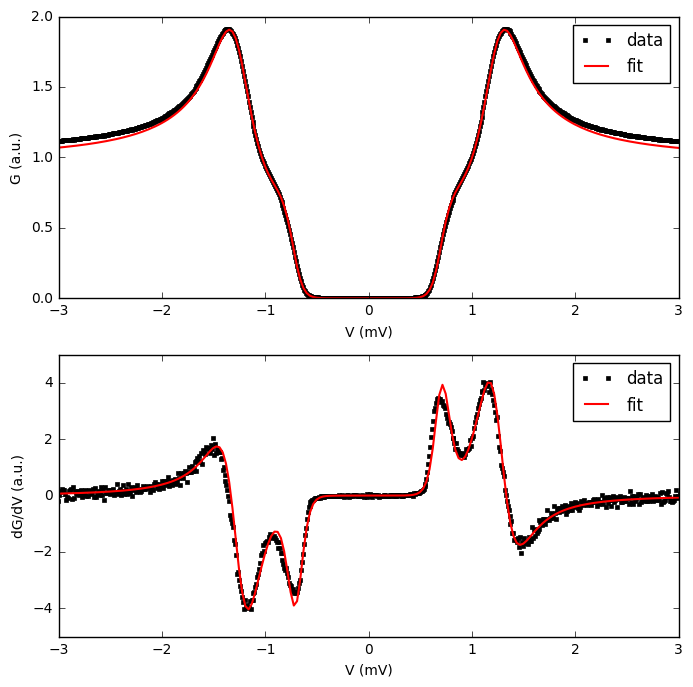

[[Fit Statistics]]
    # function evals   = 97
    # data points      = 320
    # variables        = 3
    chi-square         = 285.687
    reduced chi-square = 0.901
    Akaike info crit   = -30.296
    Bayesian info crit = -18.991
[[Variables]]
    Delta01:   1.23405428 (init= 1.233743)
    Delta02:   0.36987247 (init= 0.3633511)
    Gamma1:    0.3789091 (fixed)
    Gamma2:    1.12507 (fixed)
    Neff1:     1 (fixed)
    Neff2:     0.133194 (fixed)
    T:         0.06823072 (init= 0.04216078)
[[Correlations]] (unreported correlations are <  0.100)


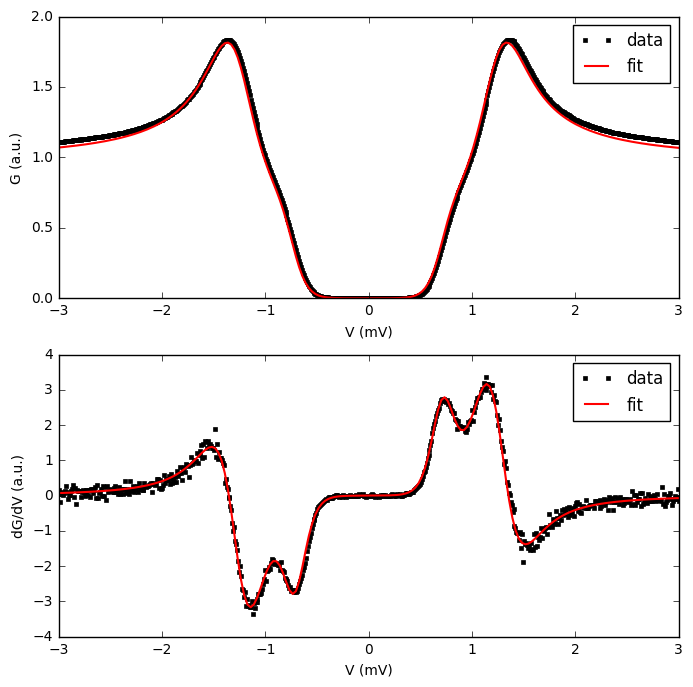

[[Fit Statistics]]
    # function evals   = 99
    # data points      = 320
    # variables        = 3
    chi-square         = 129.012
    reduced chi-square = 0.407
    Akaike info crit   = -284.694
    Bayesian info crit = -273.389
[[Variables]]
    Delta01:   1.23445011 (init= 1.234054)
    Delta02:   0.37091632 (init= 0.3698725)
    Gamma1:    0.3789091 (fixed)
    Gamma2:    1.12507 (fixed)
    Neff1:     1 (fixed)
    Neff2:     0.133194 (fixed)
    T:         0.08243414 (init= 0.06823072)
[[Correlations]] (unreported correlations are <  0.100)


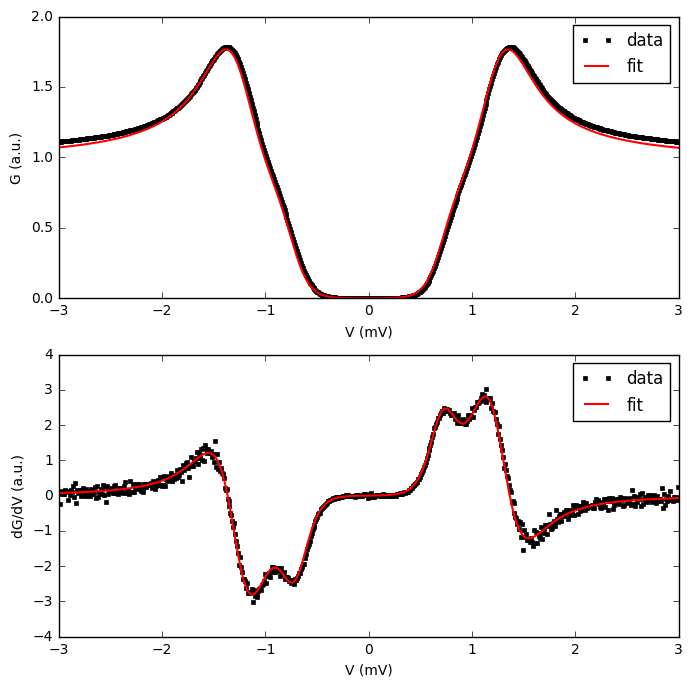

[[Fit Statistics]]
    # function evals   = 116
    # data points      = 320
    # variables        = 3
    chi-square         = 90.990
    reduced chi-square = 0.287
    Akaike info crit   = -396.423
    Bayesian info crit = -385.118
[[Variables]]
    Delta01:   1.23597663 (init= 1.23445)
    Delta02:   0.36993738 (init= 0.3709163)
    Gamma1:    0.3789091 (fixed)
    Gamma2:    1.12507 (fixed)
    Neff1:     1 (fixed)
    Neff2:     0.133194 (fixed)
    T:         0.11593073 (init= 0.08243414)
[[Correlations]] (unreported correlations are <  0.100)


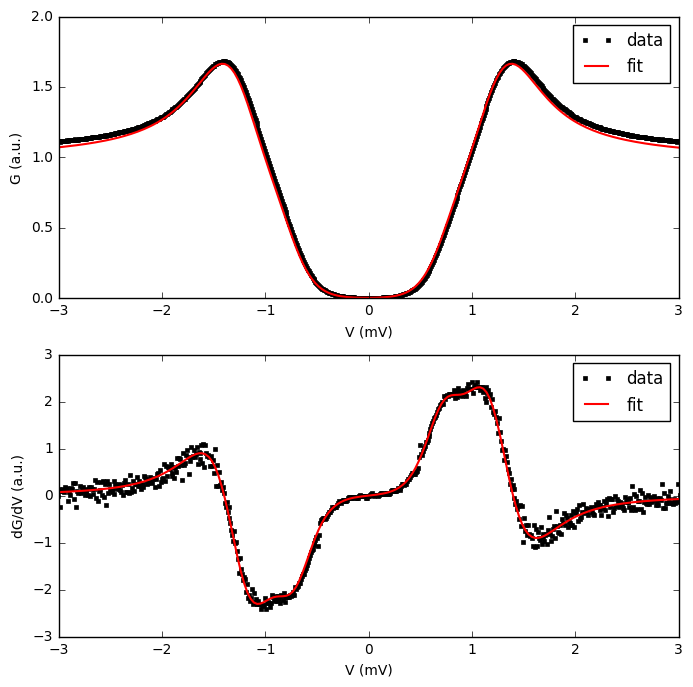

[[Fit Statistics]]
    # function evals   = 107
    # data points      = 320
    # variables        = 3
    chi-square         = 112.443
    reduced chi-square = 0.355
    Akaike info crit   = -328.681
    Bayesian info crit = -317.376
[[Variables]]
    Delta01:   1.23534862 (init= 1.235977)
    Delta02:   0.36826871 (init= 0.3699374)
    Gamma1:    0.3789091 (fixed)
    Gamma2:    1.12507 (fixed)
    Neff1:     1 (fixed)
    Neff2:     0.133194 (fixed)
    T:         0.13503980 (init= 0.1159307)
[[Correlations]] (unreported correlations are <  0.100)


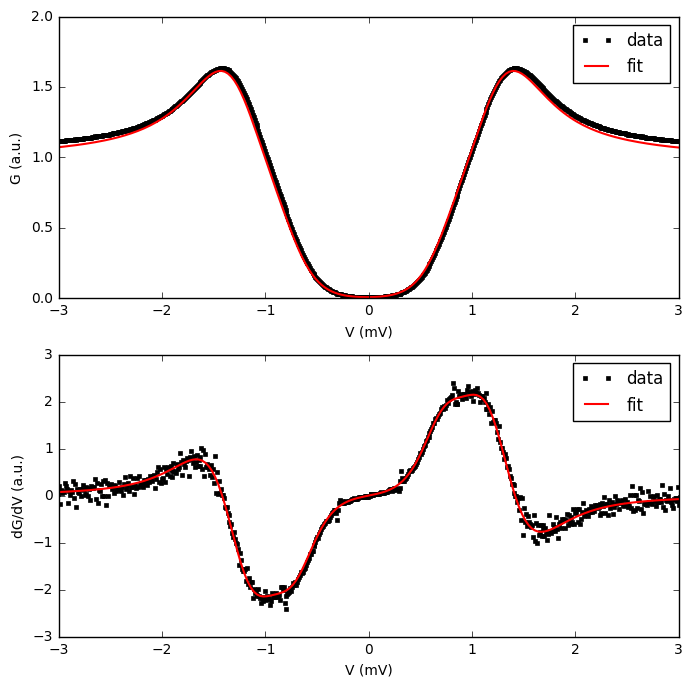

[[Fit Statistics]]
    # function evals   = 90
    # data points      = 320
    # variables        = 3
    chi-square         = 120.960
    reduced chi-square = 0.382
    Akaike info crit   = -305.316
    Bayesian info crit = -294.011
[[Variables]]
    Delta01:   1.23825512 (init= 1.235349)
    Delta02:   0.37131552 (init= 0.3682687)
    Gamma1:    0.3789091 (fixed)
    Gamma2:    1.12507 (fixed)
    Neff1:     1 (fixed)
    Neff2:     0.133194 (fixed)
    T:         0.15065984 (init= 0.1350398)
[[Correlations]] (unreported correlations are <  0.100)


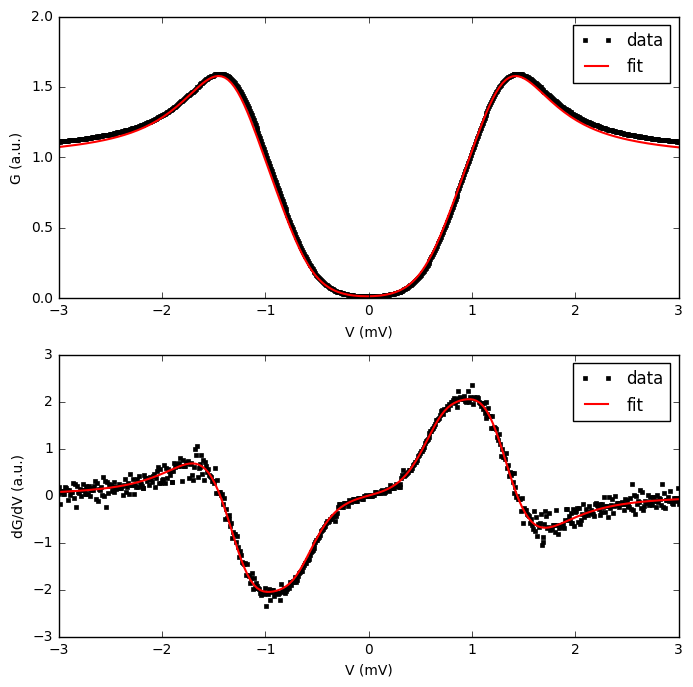

[[Fit Statistics]]
    # function evals   = 120
    # data points      = 320
    # variables        = 3
    chi-square         = 106.904
    reduced chi-square = 0.337
    Akaike info crit   = -344.845
    Bayesian info crit = -333.540
[[Variables]]
    Delta01:   1.23902913 (init= 1.238255)
    Delta02:   0.36055896 (init= 0.3713155)
    Gamma1:    0.3789091 (fixed)
    Gamma2:    1.12507 (fixed)
    Neff1:     1 (fixed)
    Neff2:     0.133194 (fixed)
    T:         0.16615977 (init= 0.1506598)
[[Correlations]] (unreported correlations are <  0.100)


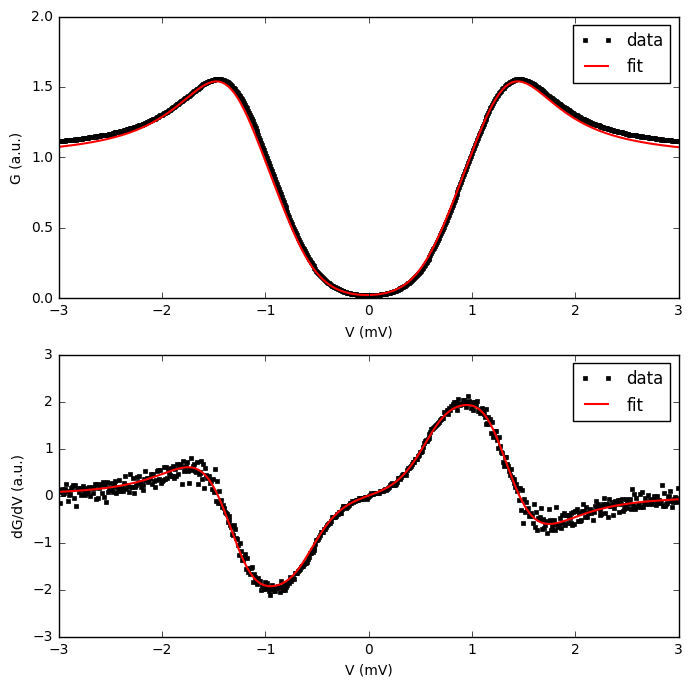

[[Fit Statistics]]
    # function evals   = 179
    # data points      = 320
    # variables        = 3
    chi-square         = 131.857
    reduced chi-square = 0.416
    Akaike info crit   = -277.712
    Bayesian info crit = -266.407
[[Variables]]
    Delta01:   1.25207879 (init= 1.239029)
    Delta02:   0.18140727 (init= 0.360559)
    Gamma1:    0.3789091 (fixed)
    Gamma2:    1.12507 (fixed)
    Neff1:     1 (fixed)
    Neff2:     0.133194 (fixed)
    T:         0.26787692 (init= 0.1661598)
[[Correlations]] (unreported correlations are <  0.100)


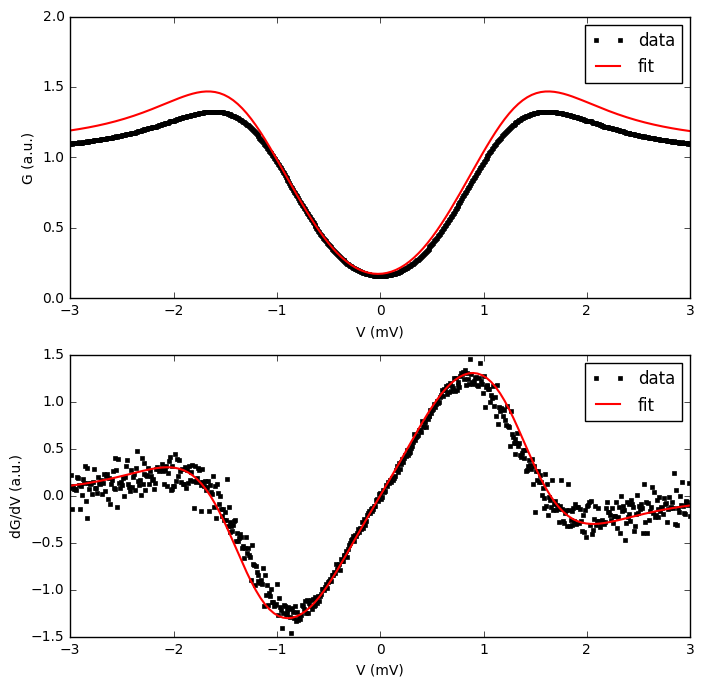

In [96]:
# fit temperatures

V, G, Gasym = LoadandSymmetrizeTemp(1,0.12)
Gerr = abs(Gasym)+0.02
params = makeParamaters([1.24,0.4,0.4,1.24,1,0.1,0.04])
start = time.time()
out = minimize(Goodness, params, args=(V, G, Gerr,[-1.5,1.5]),method='Nelder')
end = time.time()

print(fit_report(out))
fig = LoadFitPlot(V,G,out.params,[-3,3])

Tempdata = readParameters(out.params)

for k in range(2,9):
    params = out.params
    params['Gamma1'].vary = False
    params['Gamma2'].vary = False
    params['Neff2'].vary = False             
    V, G, Gasym = LoadandSymmetrizeTemp(k,0.14)
    Gerr = abs(Gasym)+0.02
    start = time.time()
    out = minimize(Goodness, params, args=(V, G, Gerr,[-1.5,1.5]),method='Nelder')
    end = time.time()
    print(fit_report(out))
    fig = LoadFitPlot(V,G,out.params,[-3,3])
    Tempdata = numpy.vstack((Tempdata,readParameters(out.params)))

### Compliation of the temperature depndence

Here is some basic complitaion of the previous fits. It seems that the sample temperature is consistent with the cryostat tmeperature above 1K, but below it, it is significantly higher.

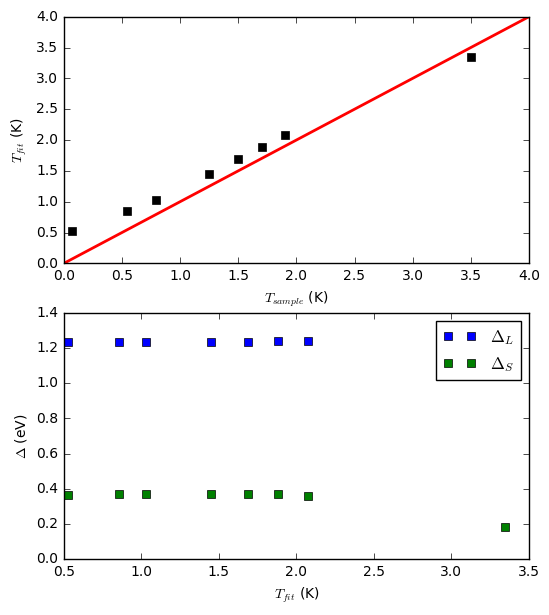

In [32]:
TempdataComp = Tempdata
Tsample = numpy.array([0.07,0.54,0.79,1.25,1.5,1.7,1.9,3.5])
T = TempdataComp.transpose()[6]/0.08
Delta01 = TempdataComp.transpose()[0]
Delta02 = TempdataComp.transpose()[1]

plt.figure(figsize=(6, 7), dpi=80)
plt.subplot(2,1,1)
plt.plot(Tsample,T,color = 'black',label = 'data',marker = 's',\
             markersize = 6,linewidth = 0)
plt.plot([0,4],[0,4],'red',linewidth = 2)
plt.xlabel('$T_{sample}$ (K)')
plt.ylabel('$T_{fit}$ (K)')

plt.subplot(2,1,2)
plt.plot(T,Delta01,label = '$\Delta_L$',marker = 's',\
             markersize = 6,linewidth = 0)
plt.plot(T,Delta02,label = '$\Delta_S$',marker = 's',\
             markersize = 6,linewidth = 0)
plt.xlabel('$T_{fit} $ (K)')
plt.ylabel('$\Delta $ (eV)')
plt.legend()
plt.show()

Now I estimate the error in the fit for the lowest teperature curve:

In [243]:
V, G, Gasym = LoadandSymmetrizeTemp(1,0.12)
Gerr = abs(Gasym)+0.02
params = makeParamaters(TempdataComp[0])
out = minimize(Goodness, params, args=(V, G, Gerr,[-1.5,1.5]))

print(fit_report(out))

[[Fit Statistics]]
    # function evals   = 17
    # data points      = 321
    # variables        = 6
    chi-square         = 533.282
    reduced chi-square = 1.693
    Akaike info crit   = 174.942
    Bayesian info crit = 197.571
[[Variables]]
    Delta01:   1.23373658 +/- 0.003581 (0.29%) (init= 1.233743)
    Delta02:   0.36352243 +/- 0.031931 (8.78%) (init= 0.3633511)
    Gamma1:    0.37876145 +/- 0.025042 (6.61%) (init= 0.3789091)
    Gamma2:    1.12460067 +/- 0.089466 (7.96%) (init= 1.12507)
    Neff1:     1 (fixed)
    Neff2:     0.13332277 +/- 0.022525 (16.90%) (init= 0.133194)
    T:         0.04218489 +/- 0.004272 (10.13%) (init= 0.04216078)
[[Correlations]] (unreported correlations are <  0.100)
    C(Delta02, Gamma2)           = -0.982 
    C(Gamma1, Neff2)             = -0.940 
    C(Gamma1, Gamma2)            =  0.876 
    C(Gamma1, T)                 = -0.867 
    C(Delta02, Gamma1)           = -0.848 
    C(Neff2, T)                  =  0.840 
    C(Gamma2, Neff2)     

Here I attempt to fit when $\Delta_S = 0$ is fixed. That is assuming that there is only one intrinsic superconducting band. The fit is not as good as with free $\Delta_S$

[[Fit Statistics]]
    # function evals   = 620
    # data points      = 321
    # variables        = 5
    chi-square         = 695.852
    reduced chi-square = 2.202
    Akaike info crit   = 258.356
    Bayesian info crit = 277.214
[[Variables]]
    Delta01:   1.26502820 (init= 1.24)
    Delta02:   0 (fixed)
    Gamma1:    0.51315112 (init= 0.4)
    Gamma2:    2.19666160 (init= 1.24)
    Neff1:     1 (fixed)
    Neff2:     0.08014662 (init= 0.1)
    T:         0.03545856 (init= 0.04)
[[Correlations]] (unreported correlations are <  0.100)


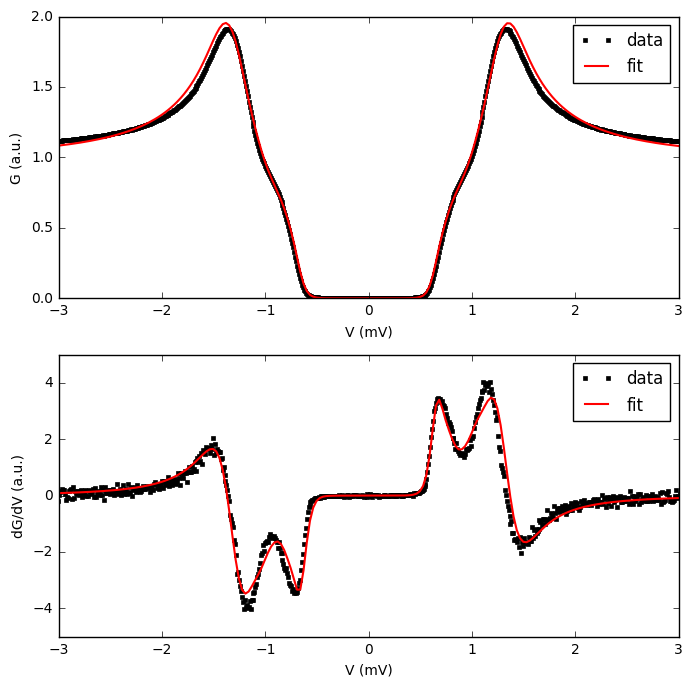

In [98]:
V, G, Gasym = LoadandSymmetrizeTemp(1,0.12)
Gerr = abs(Gasym)+0.02
params = makeParamaters([1.24,0.0,0.4,1.24,1,0.1,0.04])
params['Delta02'].vary = False  
start = time.time()
out = minimize(Goodness, params, args=(V, G, Gerr,[-1.5,1.5]),method='Nelder')
end = time.time()

print(fit_report(out))
fig = LoadFitPlot(V,G,out.params,[-3,3])

## Perpendicular field analysis

Here are 2D maps of the conductance and its derivative as a function of bias and field. The second peak can be seen to diminish significantly above 10 mT.

In [378]:
k = 1
Vs, Gs, Gasym = LoadandSymmetrizePerField(1,-0.035)
dGdVs = numpy.diff(G)/numpy.diff(V)
Bs = numpy.ones(len(V))*4*(15-(k-1)/3)

for k in range(2,47):
    V, G, Gasym = LoadandSymmetrizePerField(k,-0.035)
    dGdV = numpy.diff(G)/numpy.diff(V)
    B = numpy.ones(len(V))*4*(15-(k-1)/3)
    
    Vs = numpy.vstack((Vs, V))
    Gs = numpy.vstack((Gs, G))   
    dGdVs = numpy.vstack((dGdVs, dGdV))
    Bs = numpy.vstack((Bs, B))
    
PerB = Bs.transpose()[0]

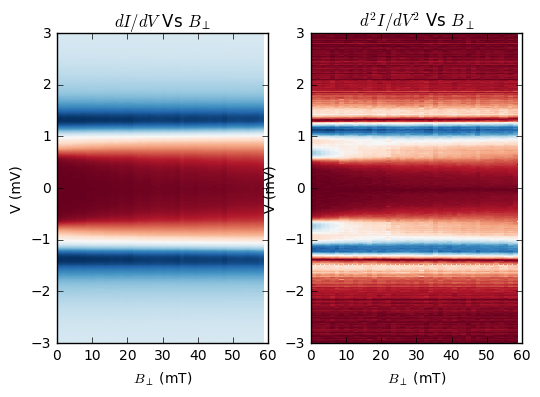

In [100]:
plt.subplot(1,2,1)
plt.pcolor(Bs,Vs,Gs,cmap = 'RdBu')
plt.ylim([-3,3])
plt.xlabel('$B_\perp$ (mT)')
plt.ylabel('V (mV)')
plt.title('$dI/dV$ Vs $B_\perp$')

plt.subplot(1,2,2)
plt.pcolor((Bs.transpose())[:][0:Vs.shape[1]-1],(Vs.transpose())[:][0:Vs.shape[1]-1],abs(dGdVs.transpose()),\
          cmap='RdBu')
plt.ylim([-3,3])
plt.xlabel('$B_\perp$ (mT)')
plt.ylabel('V (mV)')
plt.title('$d^2I/dV^2$ Vs $B_\perp$')

In [ ]:
# fitting the McMillen to all of the curves in different fields. Work in progress...

k = 46

V, G, Gasym = LoadandSymmetrizePerField(k,-0.035)
Gerr = 0*abs(Gasym)+0.05

params = makeParamaters([1.24530618,  0.30327138,  0.39547823,  1.29149346,  1, 0.12596437,0.05228405])
params['Neff2'].vary = False
start = time.time()
out = minimize(Goodness2, params, args=(V, G, Gerr,[0.4,1.3]),method='Nelder')
end = time.time()

print('B = ',4*(15-(k-1)/3),'mT, time = ',end - start)
print(fit_report(out))
fig = LoadFitPlot(V,G,out.params,[-3,3])


PerFielddata = readParameters(out.params)

for k in numpy.linspace(45,1,45):
    params = out.params             
    V, G, Gasym = LoadandSymmetrizePerField(k,-0.035)
    Gerr = 0*abs(Gasym)+0.02
    start = time.time()
    out = minimize(Goodness, params, args=(V, G, Gerr,[0.5,1.3]),method='Nelder')
    end = time.time()
#     print('B = ',4*(15-(k-1)/3),'mT, time = ',end - start)
#     print(fit_report(out))
#     fig = LoadFitPlot(V,G,out.params,[-3,3])
    PerFielddata = numpy.vstack((PerFielddata,readParameters(out.params)))

### V shape fits

Here make linear fits to the bottom of the curves. The linear fit is given by: $N(V) = N_0 (H) + \alpha |V - V_0| $. Below are show $\alpha$, N_0$ and $V_0$ as a function of field. There is a clear linear trend for the latter two. 
Below a few example of the linear fit are shown. The is shape is not perfectly V, however it is not the U shpae obtained at low fields.

In [208]:
for k in range(1,47):             
    V, G, Gasym = LoadandSymmetrizePerField(k,-0.035)
    Gerr = 0*abs(Gasym)+0.01
    out = minimize(VortexFit, makeVParamaters([1,1,0]), args=(V, G, Gerr,[-0.3,0.3]))
    if k == 1:
        PerFieldLinFit = readVParameters(out.params)
    else:       
        PerFieldLinFit = numpy.vstack((PerFieldLinFit,readVParameters(out.params)))

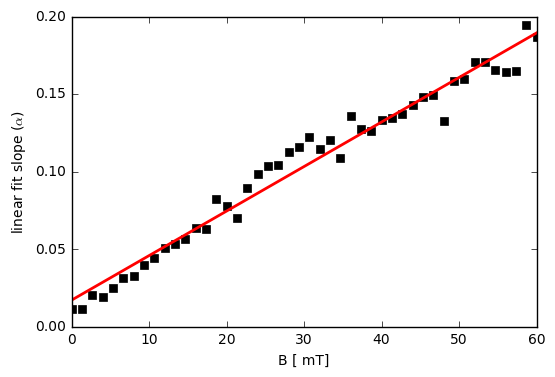

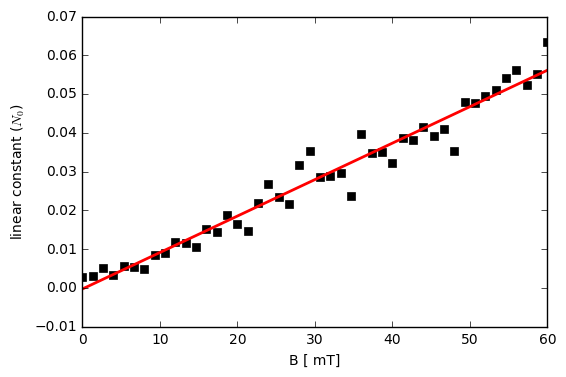

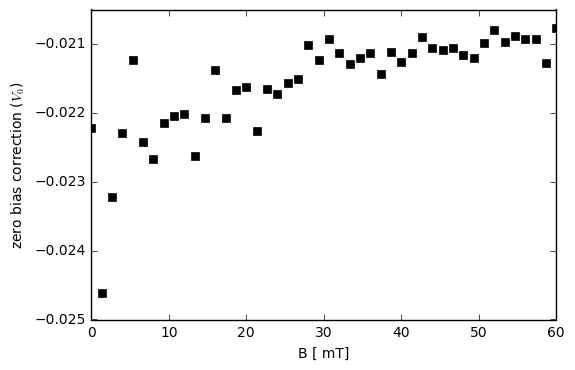

In [36]:
plt.plot(PerB,(PerFieldLinFit.transpose())[0],color = 'black',label = 'data',marker = 's',\
             markersize = 6,linewidth = 0)
linfit = numpy.polyfit(PerB,(PerFieldLinFit.transpose())[0],1)
plt.plot(PerB,linfit[0]*PerB + linfit[1],color = 'red',linewidth = 2)
plt.xlabel('B [ mT]') 
plt.ylabel('linear fit slope ($ \\alpha $)')
plt.show()


plt.plot(PerB,(PerFieldLinFit.transpose())[1],color = 'black',label = 'data',marker = 's',\
             markersize = 6,linewidth = 0)
linfit = numpy.polyfit(PerB,(PerFieldLinFit.transpose())[1],1)
plt.plot(PerB,linfit[0]*PerB + linfit[1],color = 'red',linewidth = 2)
plt.xlabel('B [ mT]') 
plt.ylabel('linear constant ($ N_0 $)')
plt.show()

plt.plot(PerB,(PerFieldLinFit.transpose())[2],color = 'black',label = 'data',marker = 's',\
             markersize = 6,linewidth = 0)
plt.xlabel('B [ mT]') 
plt.ylabel('zero bias correction ($V_0$)')
plt.show()

B =  53.3333333333 mT


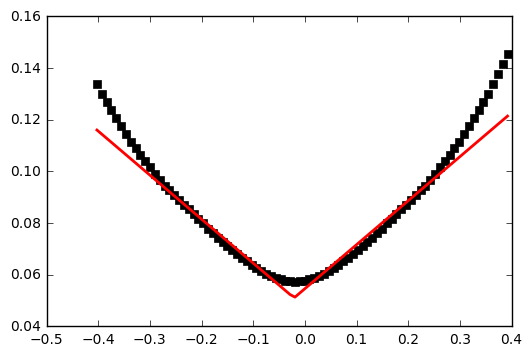

B =  46.6666666667 mT


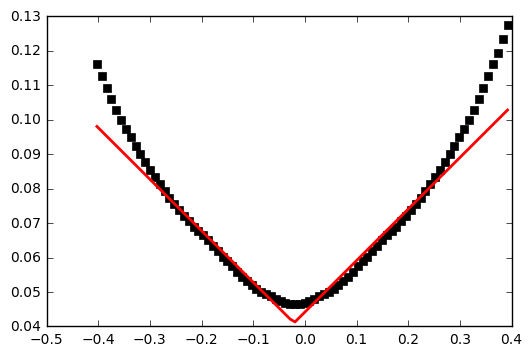

B =  40.0 mT


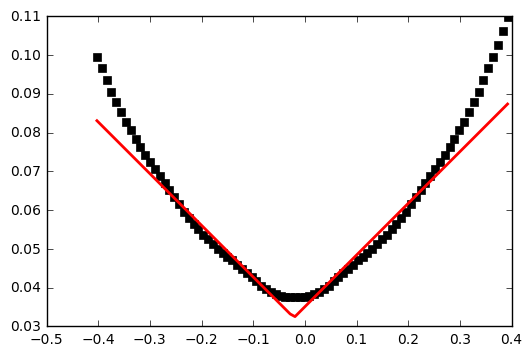

B =  33.3333333333 mT


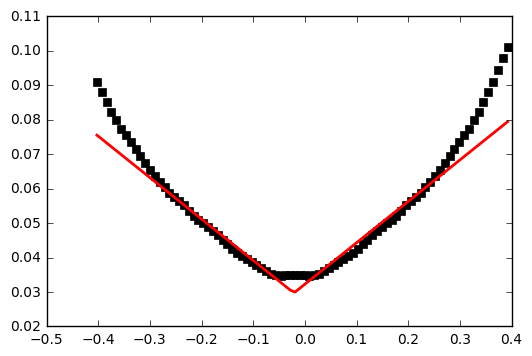

B =  26.6666666667 mT


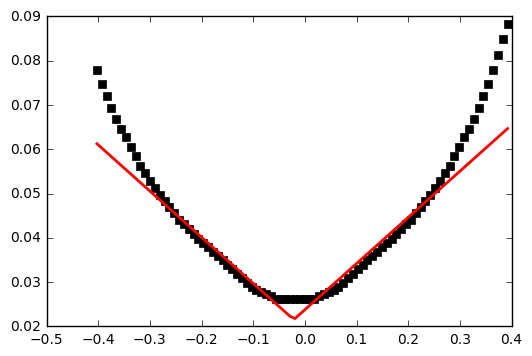

B =  20.0 mT


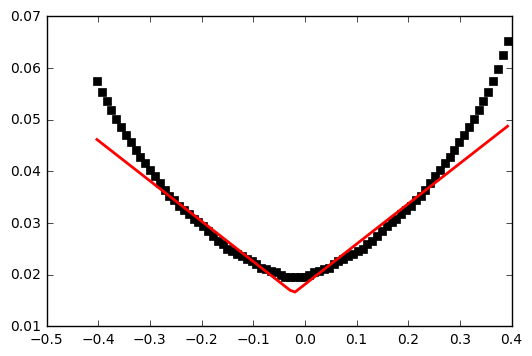

B =  13.3333333333 mT


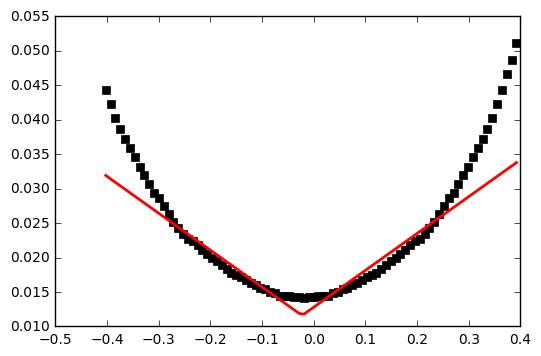

B =  6.66666666667 mT


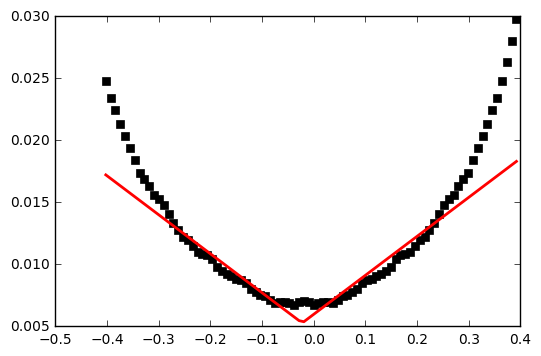

B =  0.0 mT


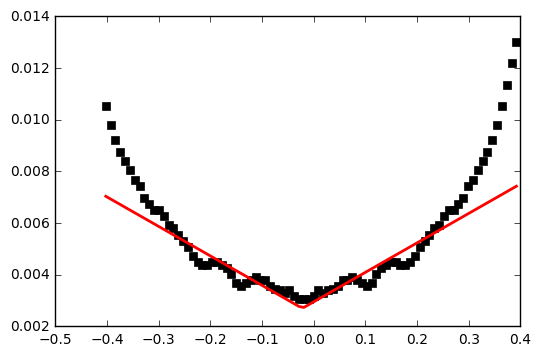

In [266]:
for j in range(2,11):
    k = j*5-4
    print('B = ',PerB[k-1],'mT')
    V, G, Gasym = LoadandSymmetrizePerField(k,-0.035)

    MinIndex = numpy.argmin(abs(V+0.4))
    MaxIndex = numpy.argmin(abs(V-0.4))
    V = V[MinIndex:MaxIndex]
    G = G[MinIndex:MaxIndex]

    plt.plot(V,G,color = 'black',label = 'data',marker = 's',\
                 markersize = 6,linewidth = 0)
    plt.plot(V,abs(PerFieldLinFit[k-1][0]*(V-PerFieldLinFit[k-1][2]))+PerFieldLinFit[k-1][1],color = 'red',linewidth = 2)
    plt.show()


## Fit of the McMillen to curves with fields

Attempting tp compare between different gfit methods - either to G or to dG/dV. Done at 35mT. Fitting to dG/dV seems nicer.

In [ ]:
V, G, Gasym = LoadandSymmetrizePerField(19,-0.035)
params = makeParamaters([1.21,0.164,0.2,1.25,1,0.11,1.3*0.08])
fig = LoadFitPlot(V,G,params,[-3,3])

out1 = minimize(Goodness, params, args = (V,G,0.02*numpy.ones(len(V)),[0.5,1.3]))
out2 = minimize(Goodness, params, args=(V, G, Gerr,[0.5,1.3]),method='Nelder')
out3 = minimize(Goodness2, params, args = (V,G,0.02*numpy.ones(len(V)),[0.5,1.3]))
out4 = minimize(Goodness2, params, args=(V, G, Gerr,[0.5,1.3]),method='Nelder')

Fitting according to G, default method
[[Fit Statistics]]
    # function evals   = 115
    # data points      = 85
    # variables        = 6
    chi-square         = 8.533
    reduced chi-square = 0.108
    Akaike info crit   = -183.386
    Bayesian info crit = -168.730
[[Variables]]
    Delta01:   1.19841306 +/- 0.002993 (0.25%) (init= 1.21)
    Delta02:   9.0492e-09 +/- 7.63e-05 (843519.26%) (init= 0.164)
    Gamma1:    0.12346941 +/- 0.061024 (49.42%) (init= 0.2)
    Gamma2:    1.36129026 +/- 0.024540 (1.80%) (init= 1.25)
    Neff1:     1 (fixed)
    Neff2:     0.19561503 +/- 0.059876 (30.61%) (init= 0.11)
    T:         0.11957200 +/- 0.007111 (5.95%) (init= 0.104)
[[Correlations]] (unreported correlations are <  0.100)
    C(Gamma1, Neff2)             = -0.999 
    C(Gamma1, T)                 = -0.998 
    C(Neff2, T)                  =  0.995 
    C(Delta01, Neff2)            =  0.965 
    C(Delta01, Gamma1)           = -0.953 
    C(Gamma2, T)                 = -0.951 
    C(G

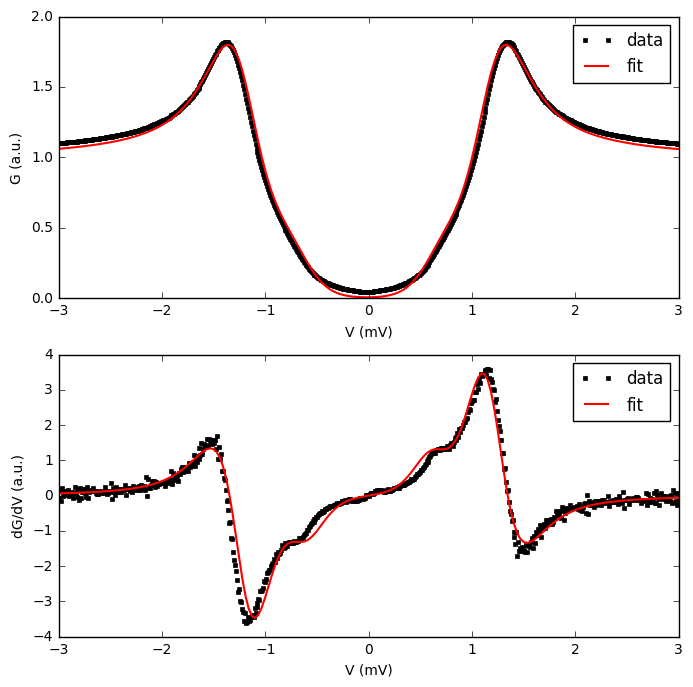

Fitting according to dG/dV, Default method
[[Fit Statistics]]
    # function evals   = 14002
    # data points      = 84
    # variables        = 6
    chi-square         = 0.158
    reduced chi-square = 0.002
    Akaike info crit   = -515.357
    Bayesian info crit = -500.772
[[Variables]]
    Delta01:   1.20617586 +/- 0.013456 (1.12%) (init= 1.21)
    Delta02:   0.38495111 +/- 0.201070 (52.23%) (init= 0.164)
    Gamma1:    0.04703864 +/- 0.155850 (331.32%) (init= 0.2)
    Gamma2:    0.67646350 +/- 0.475873 (70.35%) (init= 1.25)
    Neff1:     1 (fixed)
    Neff2:     0.24300280 +/- 0.096142 (39.56%) (init= 0.11)
    T:         0.12740358 +/- 0.022174 (17.41%) (init= 0.104)
[[Correlations]] (unreported correlations are <  0.100)
    C(Gamma1, T)                 = -0.998 
    C(Neff2, T)                  =  0.984 
    C(Delta01, Neff2)            =  0.983 
    C(Gamma1, Neff2)             = -0.981 
    C(Delta01, T)                =  0.975 
    C(Delta01, Gamma1)           = -0.963 
  

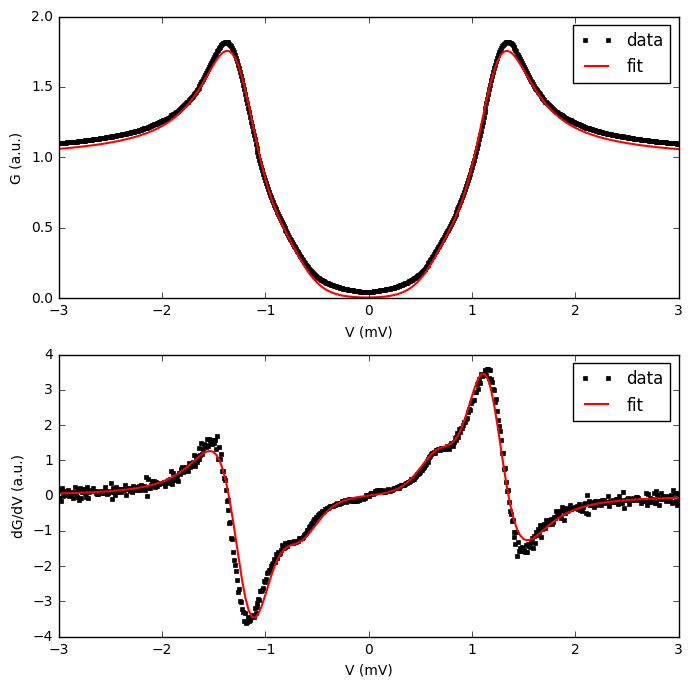

In [299]:
V, G, Gasym = LoadandSymmetrizePerField(19,-0.035)

print('Fitting according to G, default method')
print(fit_report(out1))
fig = LoadFitPlot(V,G,out1.params,[-3,3])
# print('Fitting according to G, Nelder method')
# print(fit_report(out2))
# fig = LoadFitPlot(V,G,out2.params,[-3,3])
print('Fitting according to dG/dV, Default method')
print(fit_report(out3))
fig = LoadFitPlot(V,G,out3.params,[-3,3])
# print('Fitting according to dG/dV, Nelder method')
# print(fit_report(out4))
# fig = LoadFitPlot(V,G,out4.params,[-3,3])



Using the the second derivative as the selected method for calculating the fit, below we see the results of fitting the entire field range. In this fit $\Delta_1$ and $\Delta_2$ were kept fixed. In the zero field $N_\text{eff2}$ was allowd to change and then kept also fixed. First we see the results of the compilation and then the fits themselves.

In [5]:
k = 46
V, G, Gasym = LoadandSymmetrizePerField(0,-0.035)
Gerr = 0.02*numpy.ones(len(V));
params = makeParamaters([1.206,0.385,0.05,0.67,1,0.2,0.12])
params['Delta01'].vary = True
params['Delta02'].vary = True
# fig = LoadFitPlot(V,G,params,[-3,3])

start = time.time()
out = minimize(Goodness2, params, args = (V,G,Gerr,[0.5,1.3]))
print(k,': ',time.time() - start)

PerFieldDataFreeDeltas = readParameters(out.params)
PerFielddataFreeDeltasRaw = [out]
for k in range(45,0,-1):
    params = out.params
    params['Neff2'].vary = False             
    V, G, Gasym = LoadandSymmetrizePerField(k,-0.035)
    start = time.time()
    out = minimize(Goodness2, params, args=(V, G, Gerr,[0.5,1.3]))
    end = time.time()
    print(k,': ',time.time() - start)
    PerFieldDataFreeDeltas = numpy.vstack((PerFieldDataFreeDeltas,readParameters(out.params)))
    PerFielddataFreeDeltasRaw.append(out)

46 :  46.76967525482178
45 :  11.0906343460083
44 :  11.207640886306763
43 :  8.82350468635559
42 :  11.149637699127197
41 :  11.13063669204712
40 :  11.213641166687012
39 :  13.618778944015503
38 :  13.883794069290161
37 :  13.634779930114746
36 :  11.160638332366943
35 :  13.713784217834473
34 :  16.147923469543457
33 :  11.279645204544067
32 :  11.215641498565674
31 :  11.166638612747192
30 :  11.220641851425171
29 :  16.180925369262695
28 :  14.002800703048706
27 :  21.83124876022339
26 :  16.275931119918823
25 :  17.448997974395752
24 :  8.750500679016113
23 :  13.90979552268982
22 :  13.647780418395996
21 :  13.730785369873047
20 :  16.107921361923218
19 :  460.48933839797974
18 :  1784.7380812168121
17 :  1661.1700134277344
16 :  370.3691837787628
15 :  4815.996459245682
14 :  26.534517765045166
13 :  11.093634605407715
12 :  11.020630121231079
11 :  11.009629726409912
10 :  40.49931621551514
9 :  20.871193647384644
8 :  11.022630453109741
7 :  38.97922945022583
6 :  646.6459860

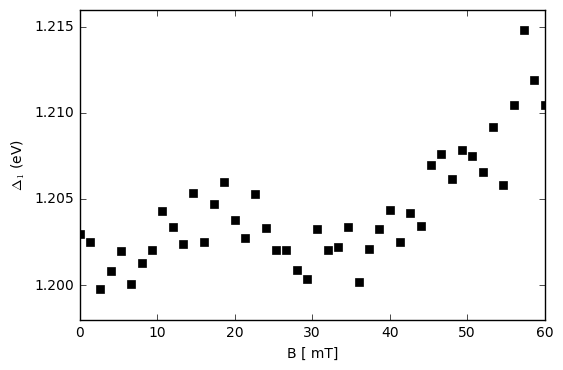

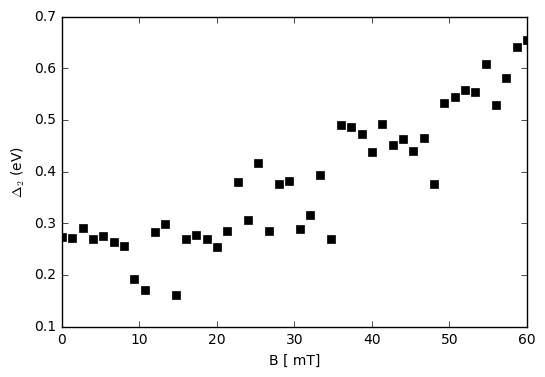

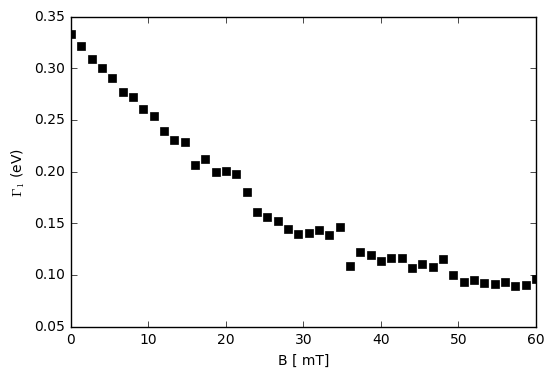

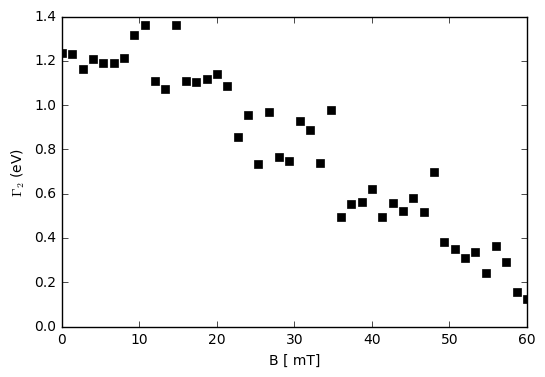

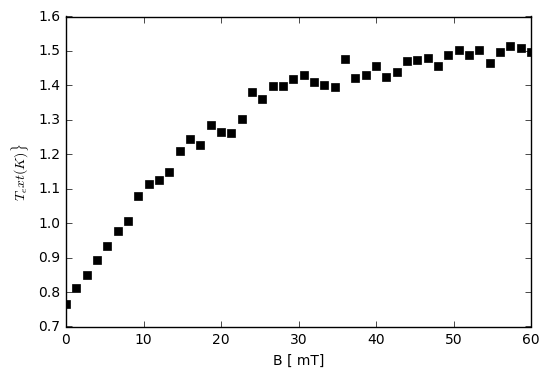

In [9]:
plt.plot(PerB,(numpy.flipud(PerFieldDataFreeDeltas).transpose())[0],color = 'black',label = 'data',marker = 's',\
             markersize = 6,linewidth = 0)
plt.xlabel('B [ mT]') 
plt.ylabel('$\Delta_1$ (eV)')
plt.show()

plt.plot(PerB,(numpy.flipud(PerFieldDataFreeDeltas).transpose())[1],color = 'black',label = 'data',marker = 's',\
             markersize = 6,linewidth = 0)
plt.xlabel('B [ mT]') 
plt.ylabel('$\Delta_2$ (eV)')
plt.show()

plt.plot(PerB,(numpy.flipud(PerFieldDataFreeDeltas).transpose())[2],color = 'black',label = 'data',marker = 's',\
             markersize = 6,linewidth = 0)
plt.xlabel('B [ mT]') 
plt.ylabel('$\Gamma_1$ (eV)')
plt.show()

plt.plot(PerB,(numpy.flipud(PerFieldDataFreeDeltas).transpose())[3],color = 'black',label = 'data',marker = 's',\
             markersize = 6,linewidth = 0)
plt.xlabel('B [ mT]') 
plt.ylabel('$\Gamma_2$ (eV)')
plt.show()

plt.plot(PerB,(numpy.flipud(PerFieldDataFreeDeltas).transpose())[6]/0.08,color = 'black',label = 'data',marker = 's',\
             markersize = 6,linewidth = 0)
plt.xlabel('B [ mT]') 
plt.ylabel('$T_\text{fit$ (K)}')
plt.show()

B =  0.0


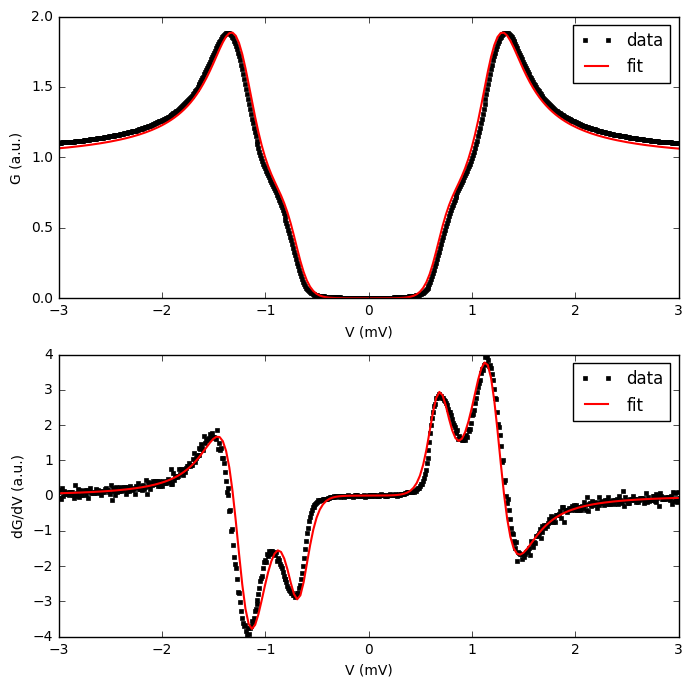

B =  1.33333333333


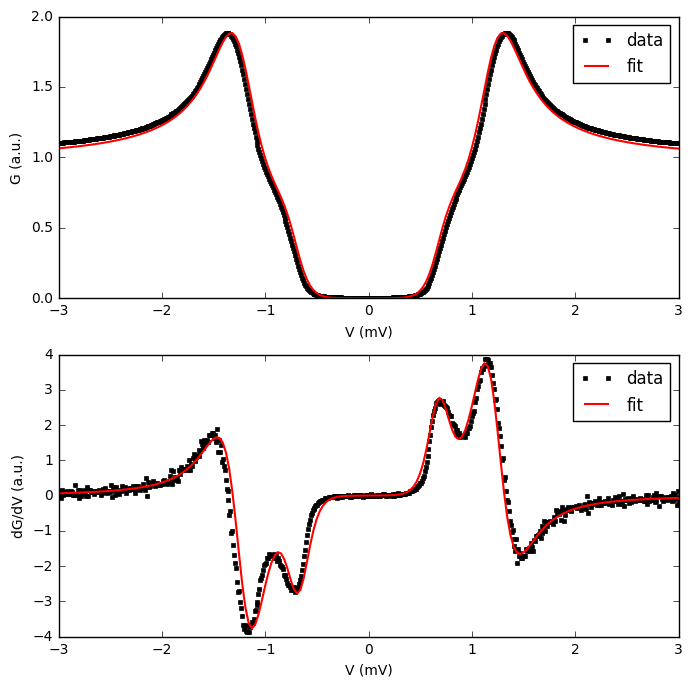

B =  2.66666666667


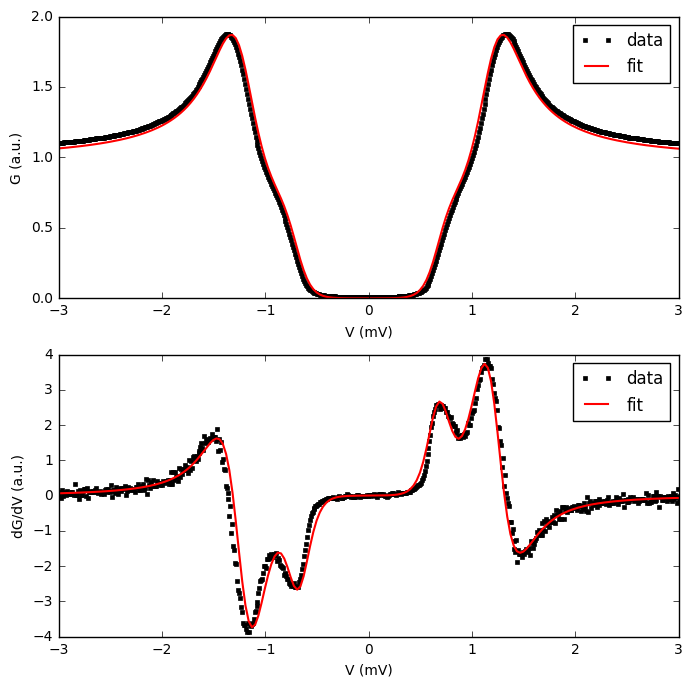

B =  4.0


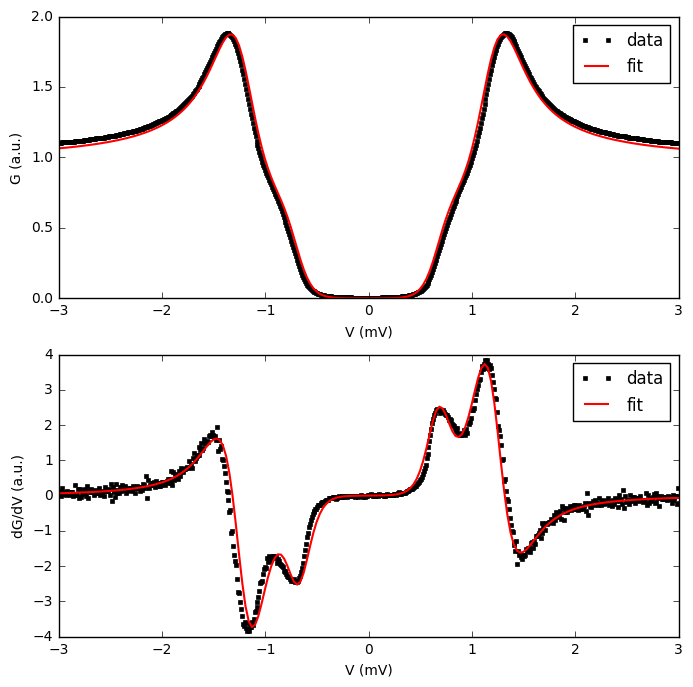

B =  5.33333333333


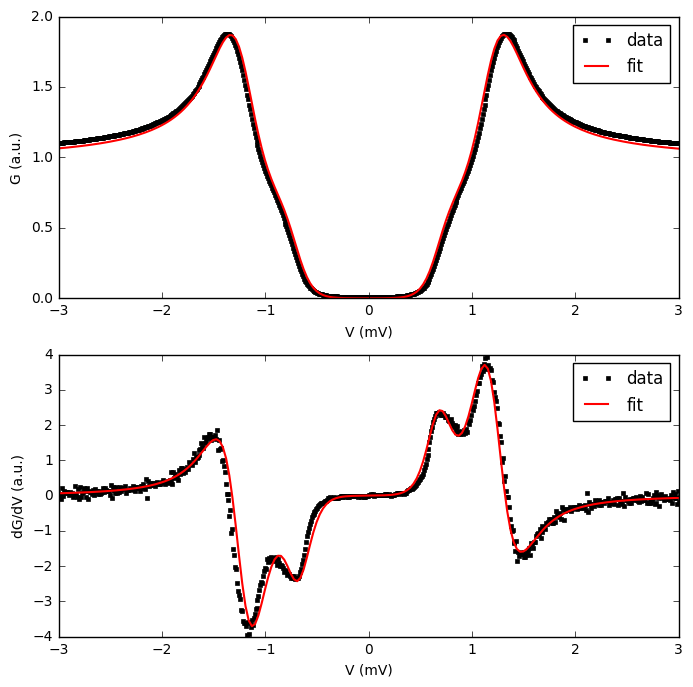

B =  6.66666666667


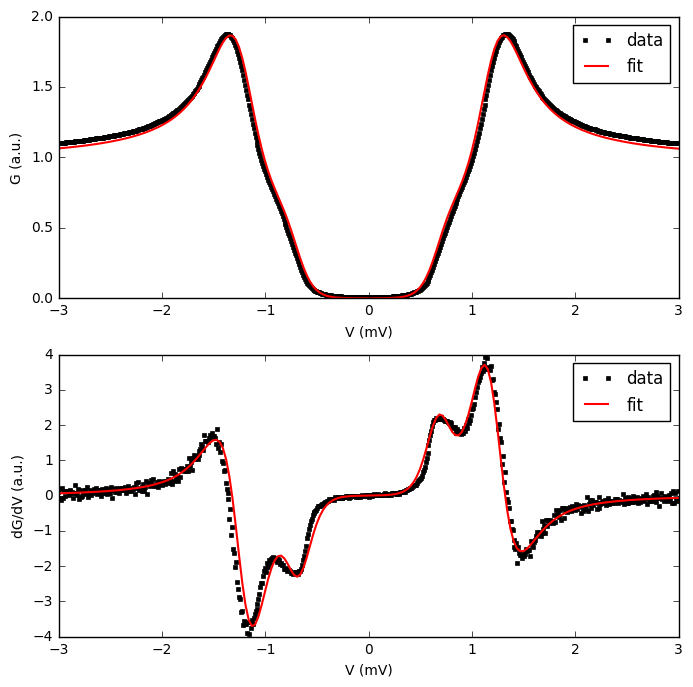

B =  8.0


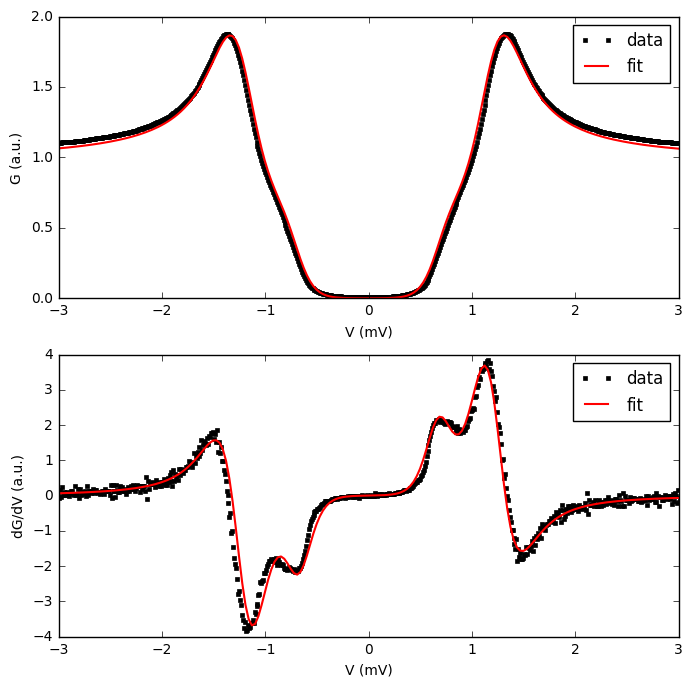

B =  9.33333333333


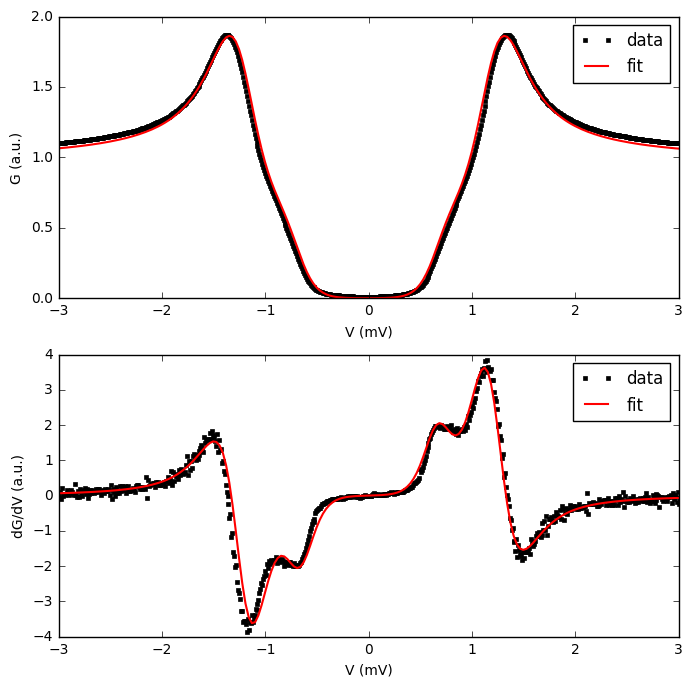

B =  10.6666666667


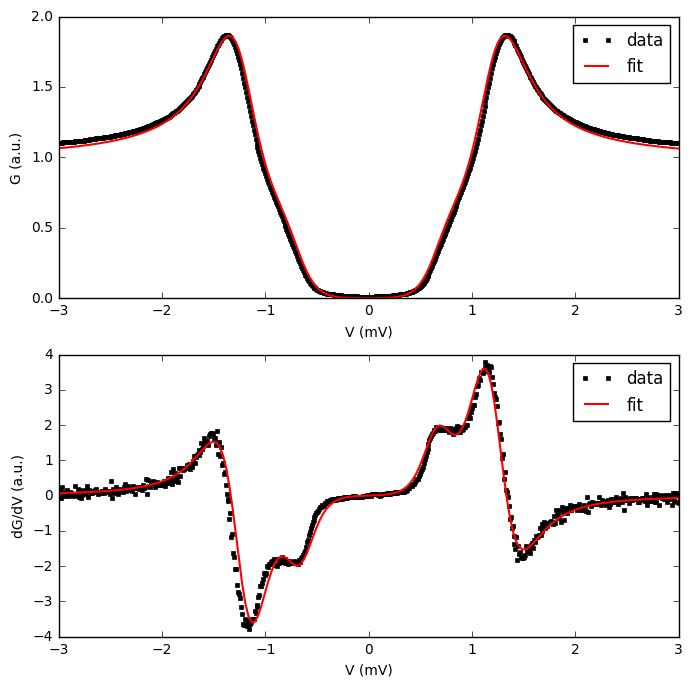

B =  12.0


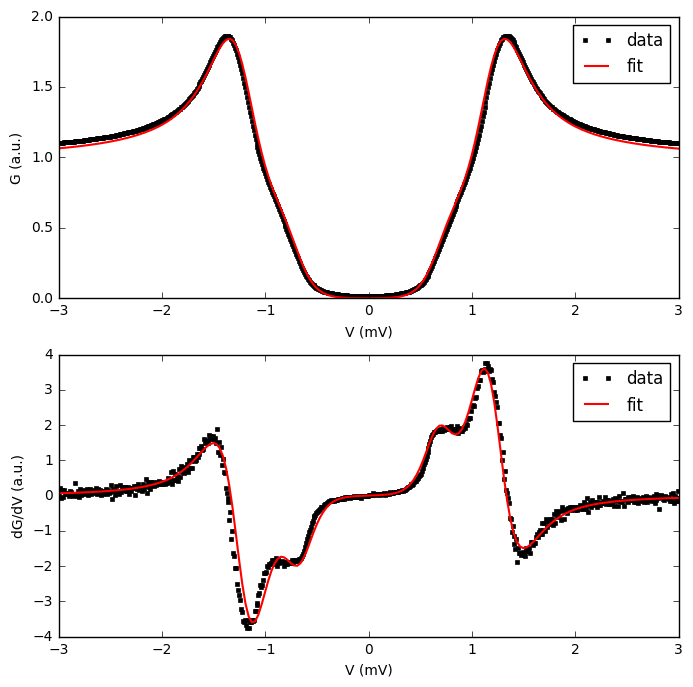

B =  13.3333333333


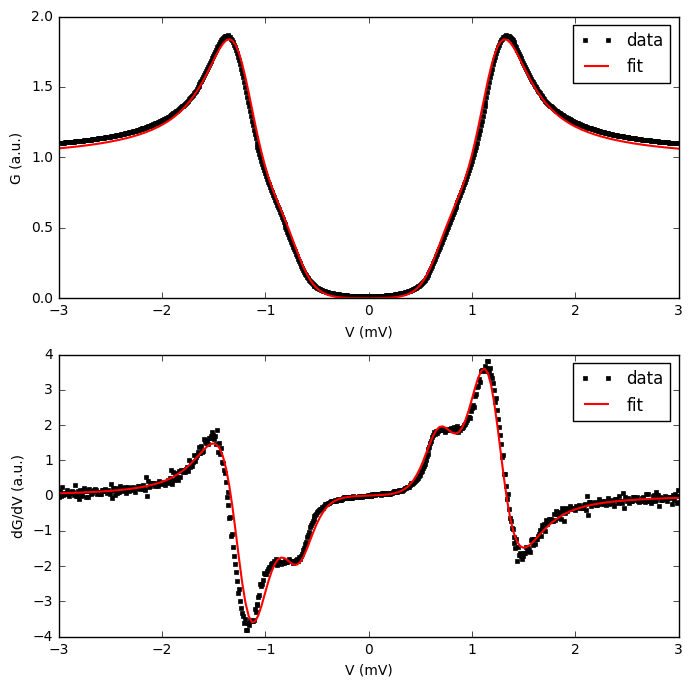

B =  14.6666666667


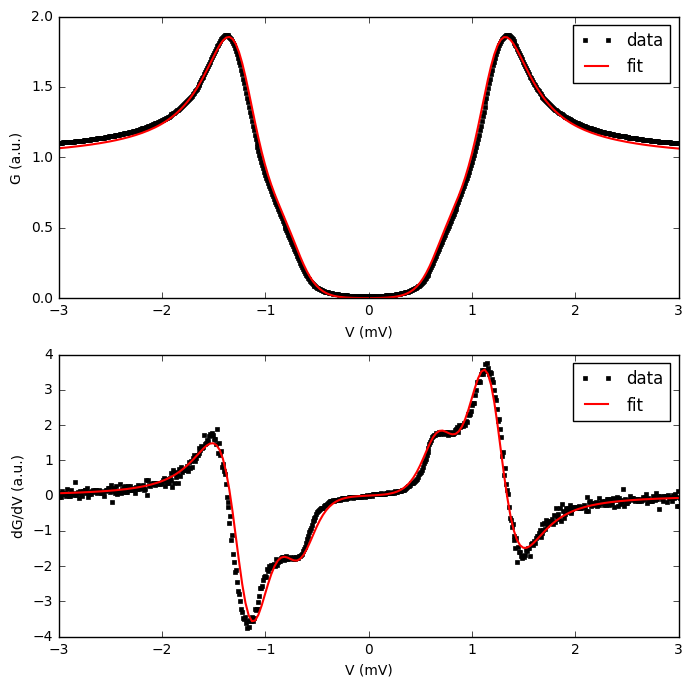

B =  16.0


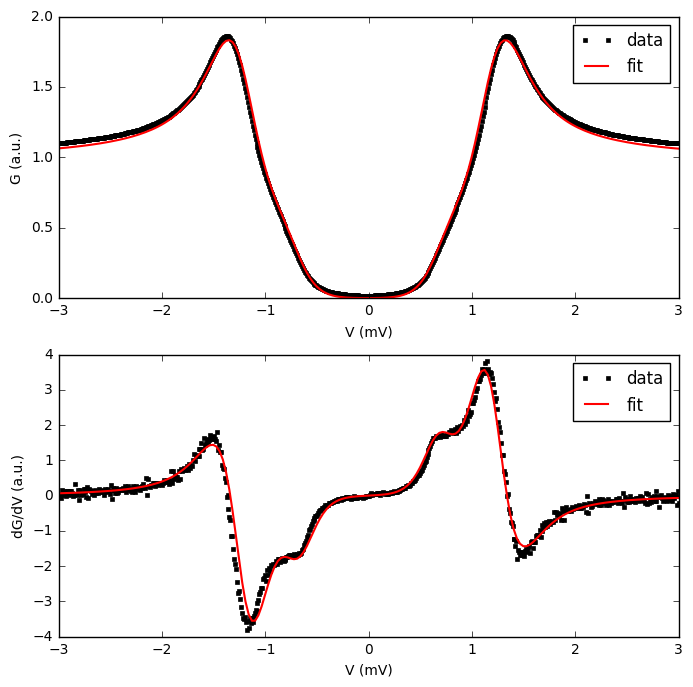

B =  17.3333333333


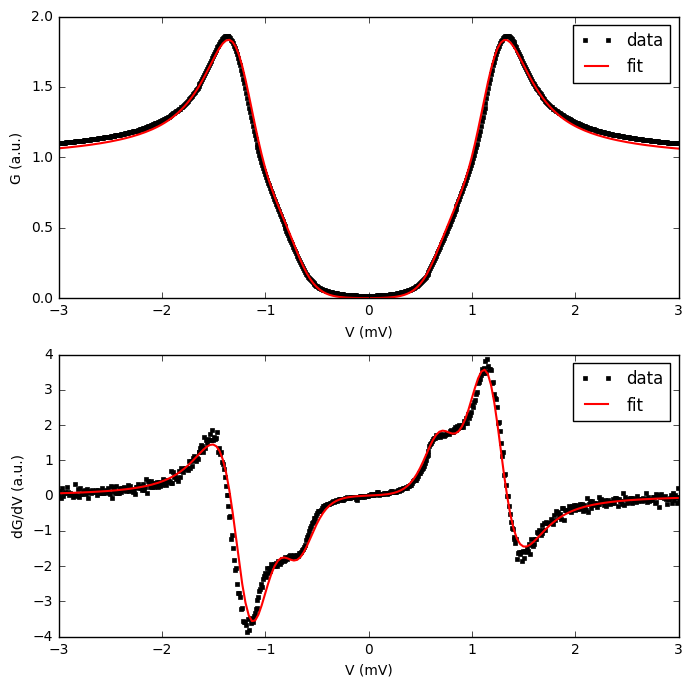

B =  18.6666666667


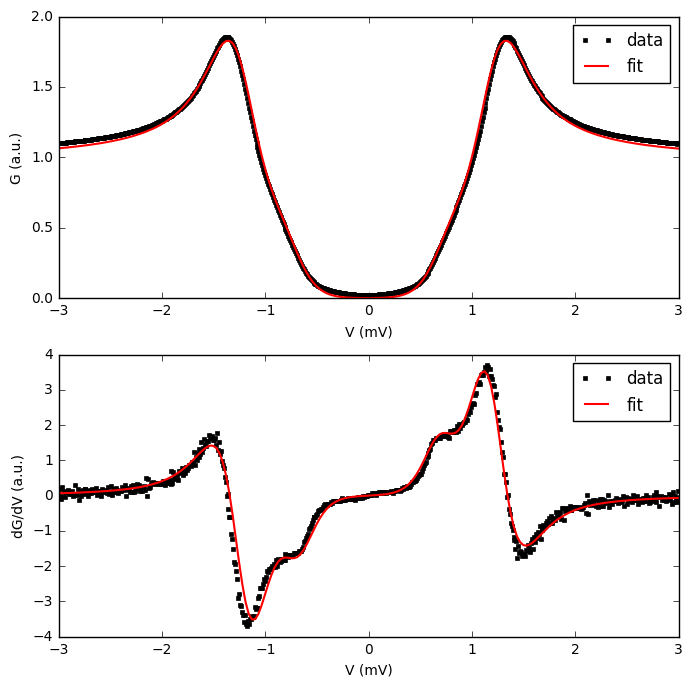

B =  20.0


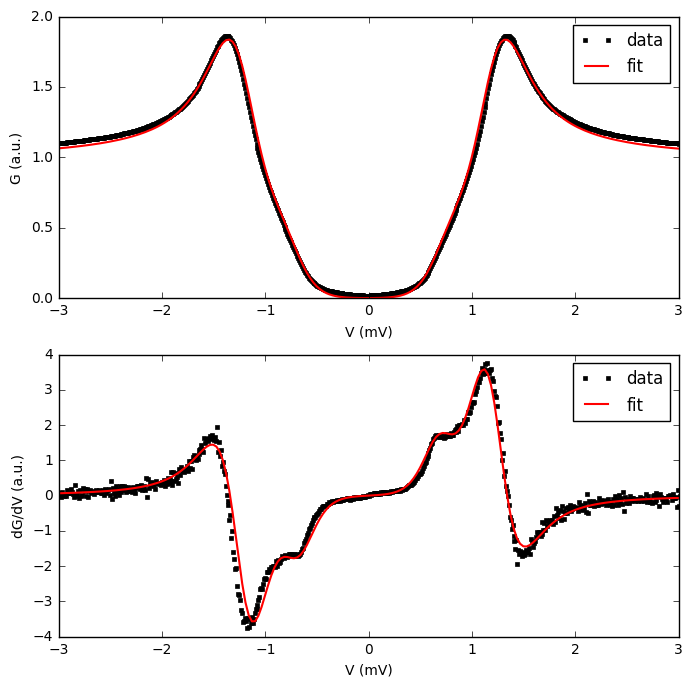

B =  21.3333333333


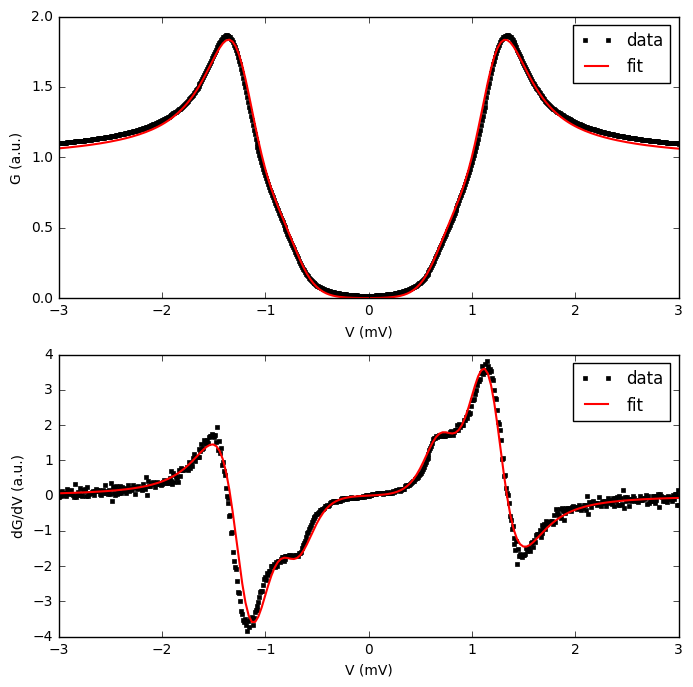

B =  22.6666666667


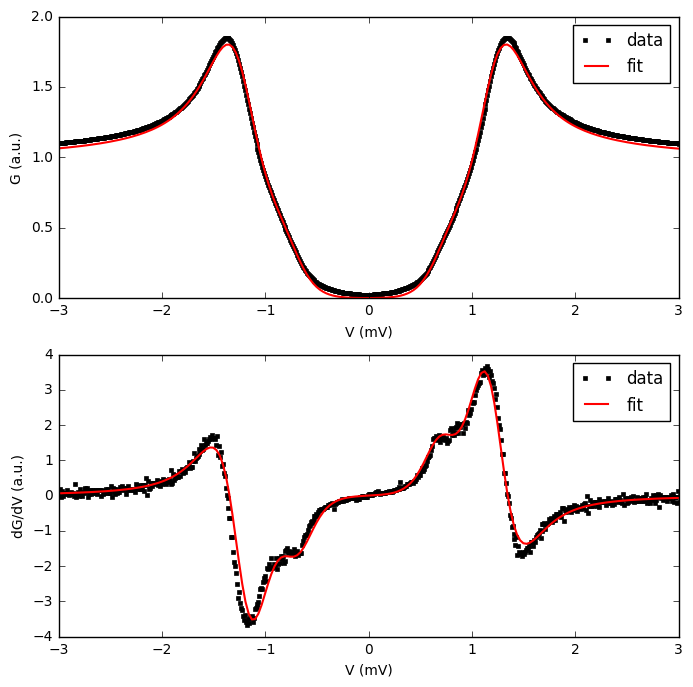

B =  24.0


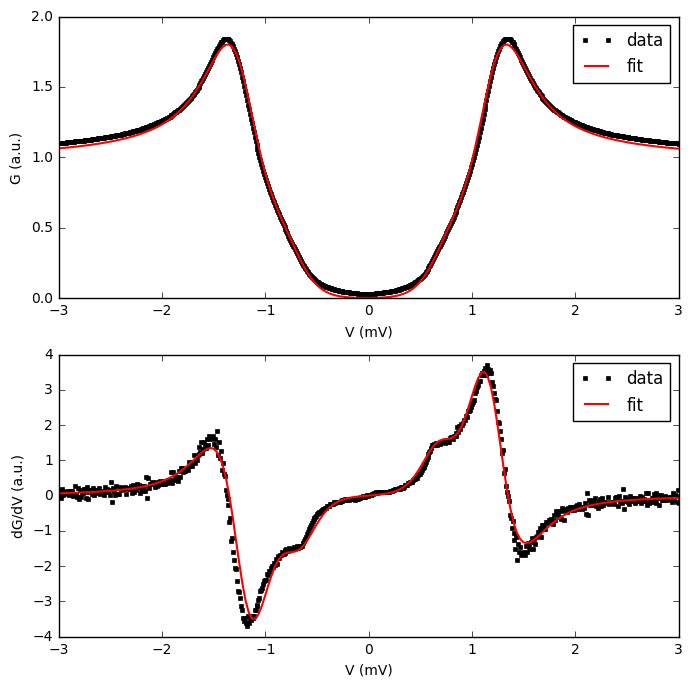

B =  25.3333333333


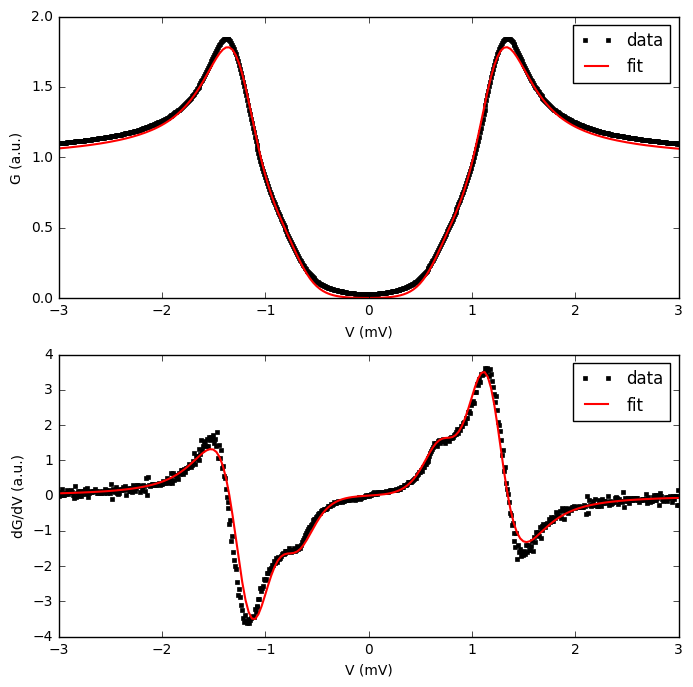

B =  26.6666666667


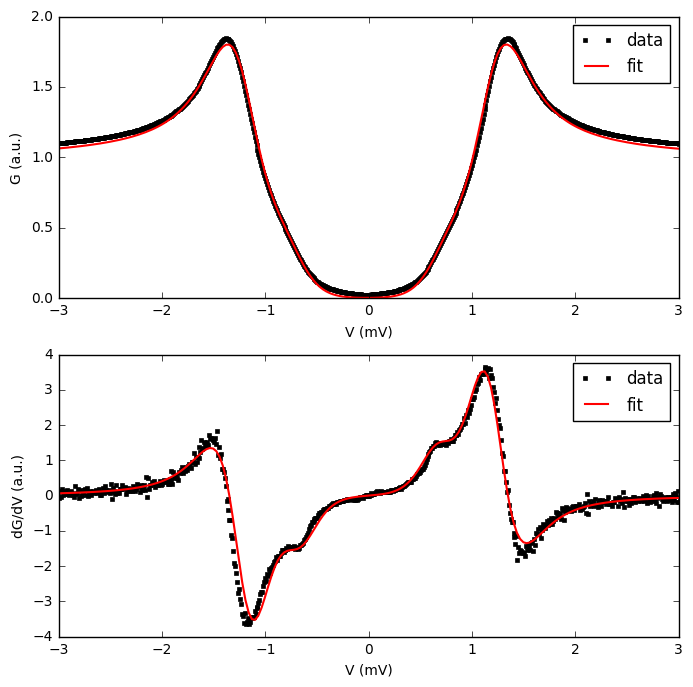

B =  28.0


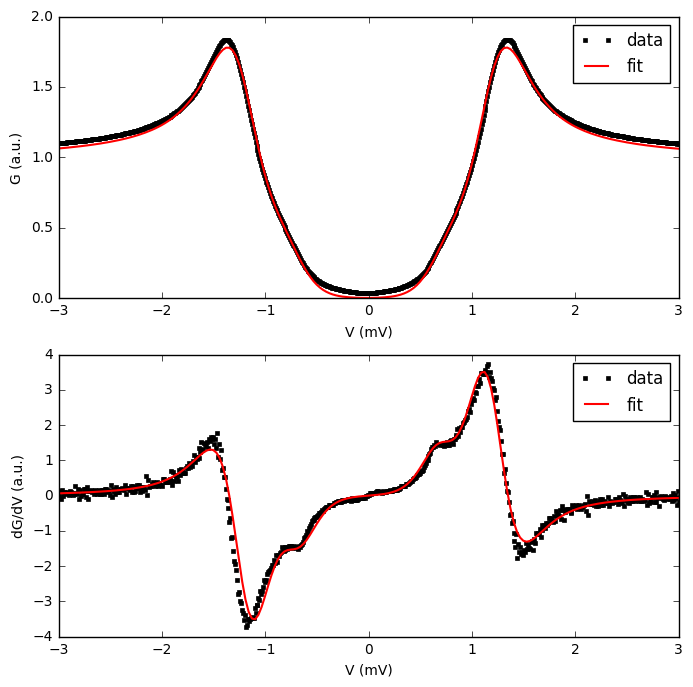

B =  29.3333333333


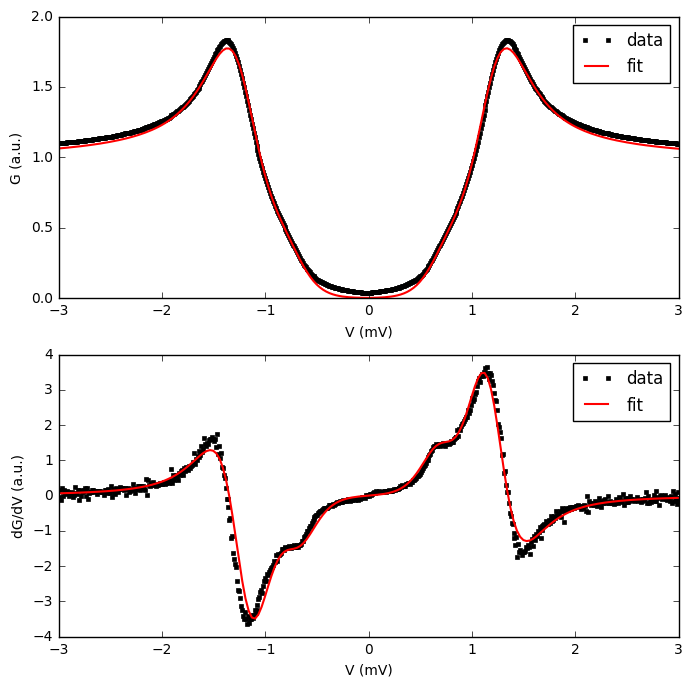

B =  30.6666666667


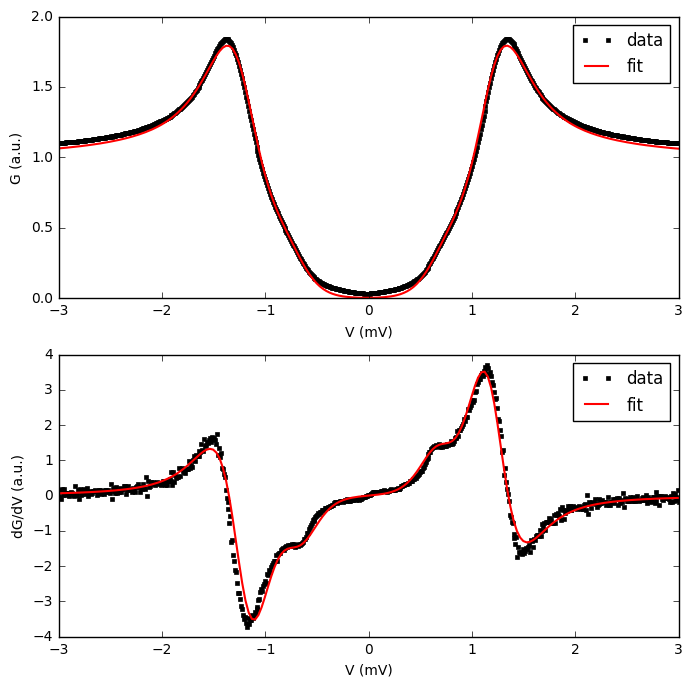

B =  32.0


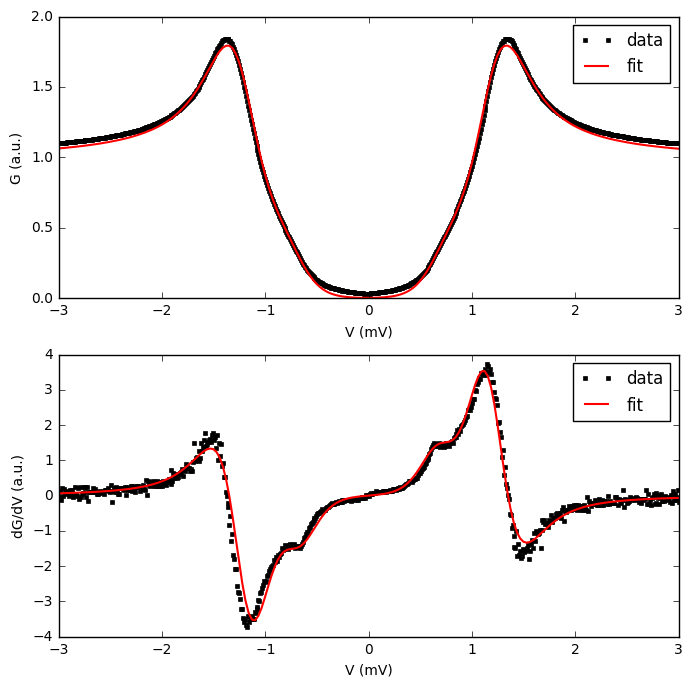

B =  33.3333333333


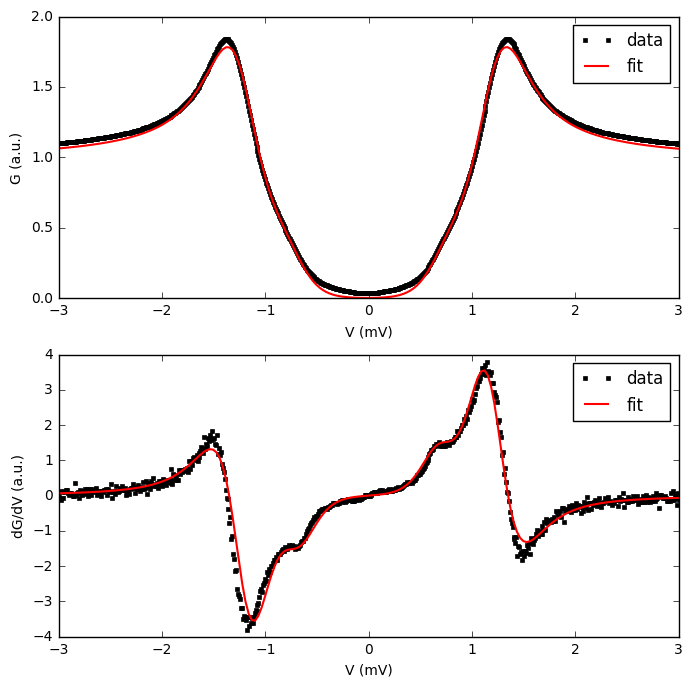

B =  34.6666666667


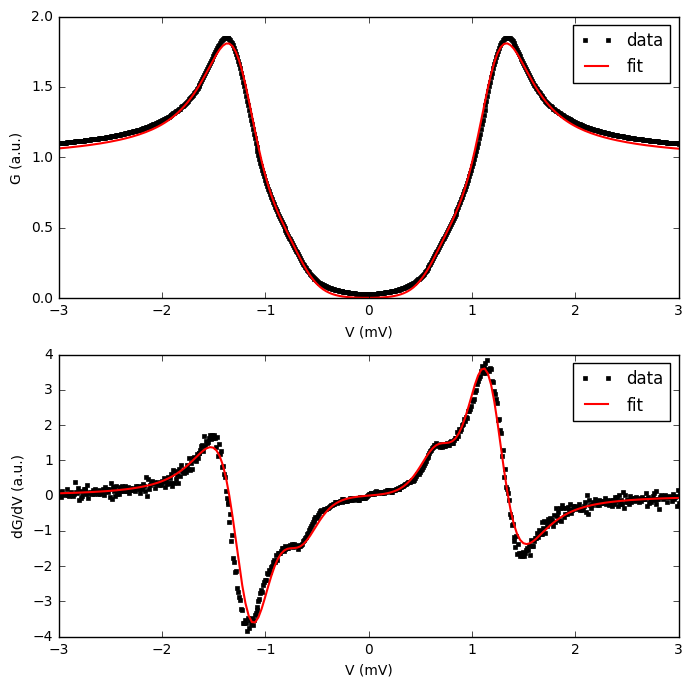

B =  36.0


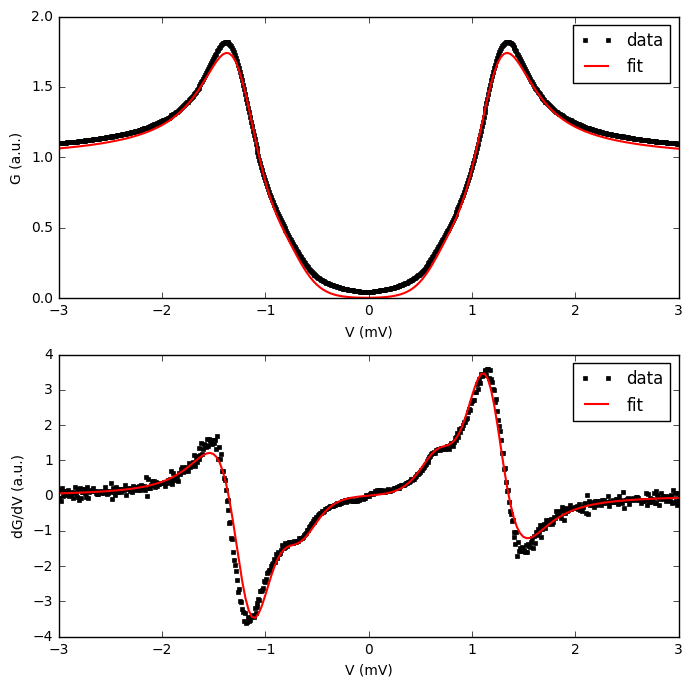

B =  37.3333333333


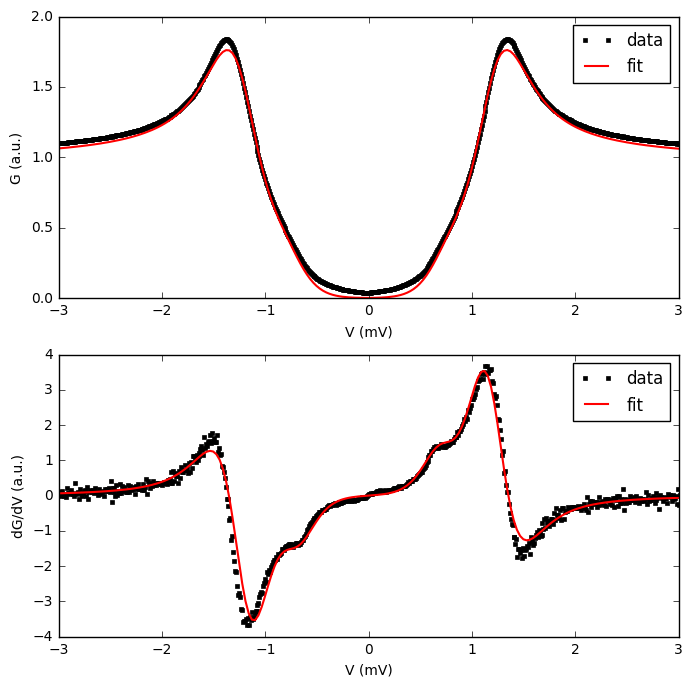

B =  38.6666666667


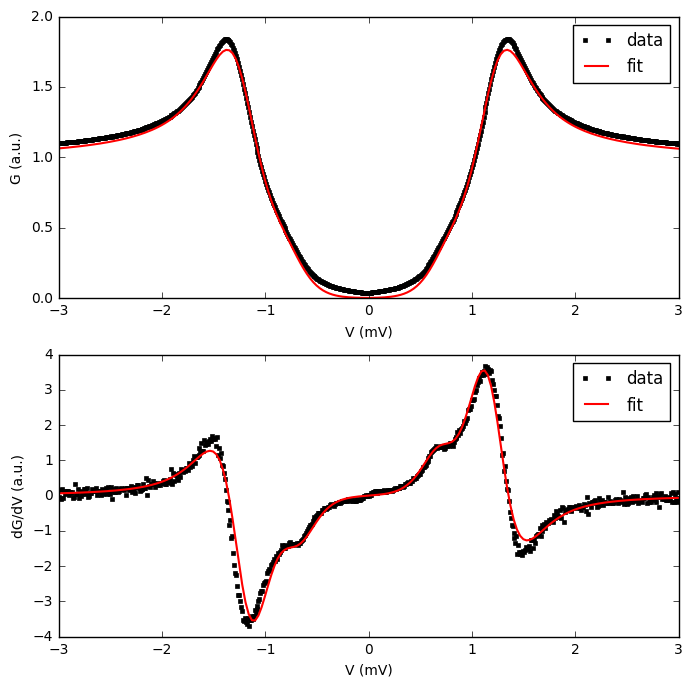

B =  40.0


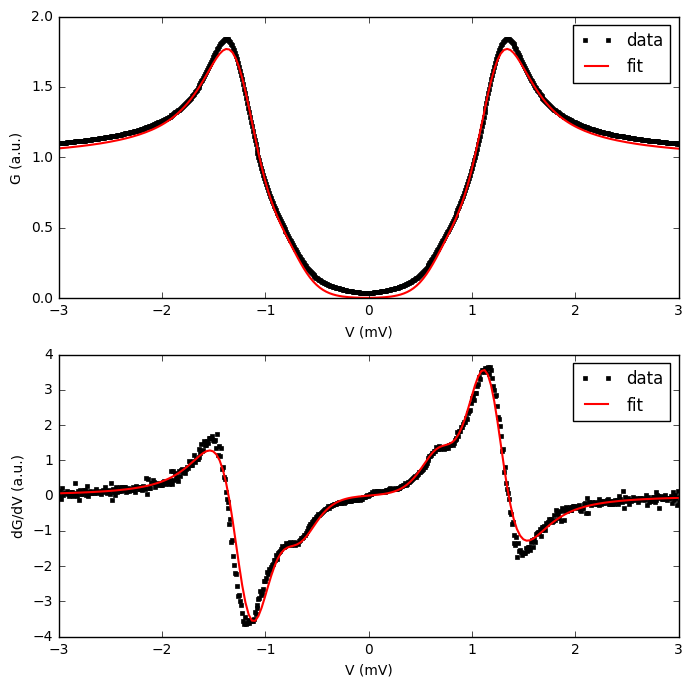

B =  41.3333333333


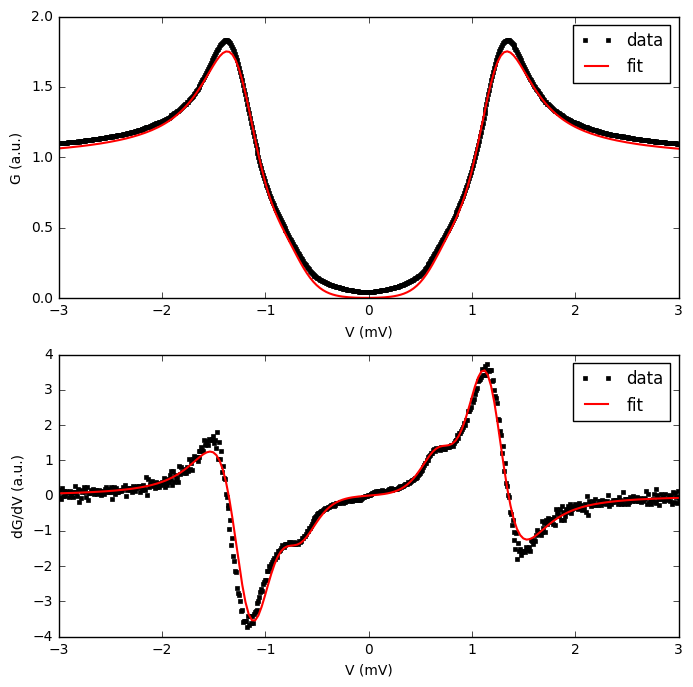

B =  42.6666666667


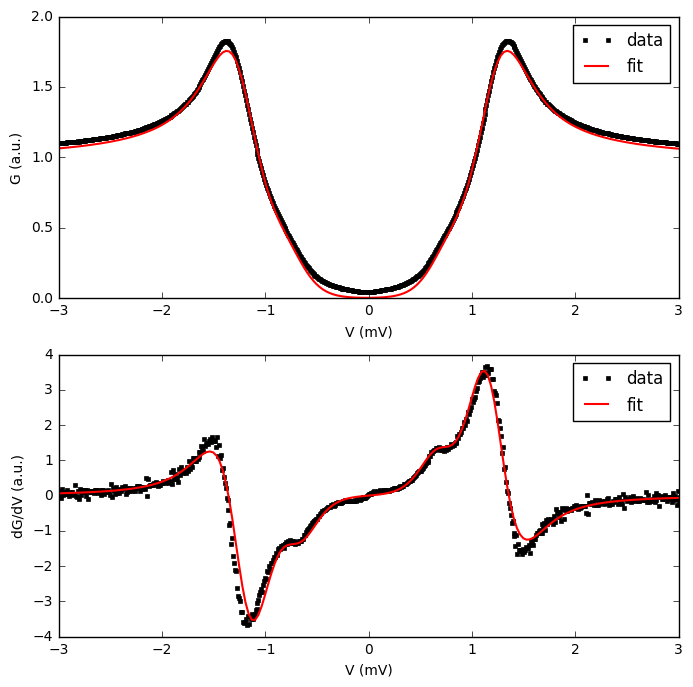

B =  44.0


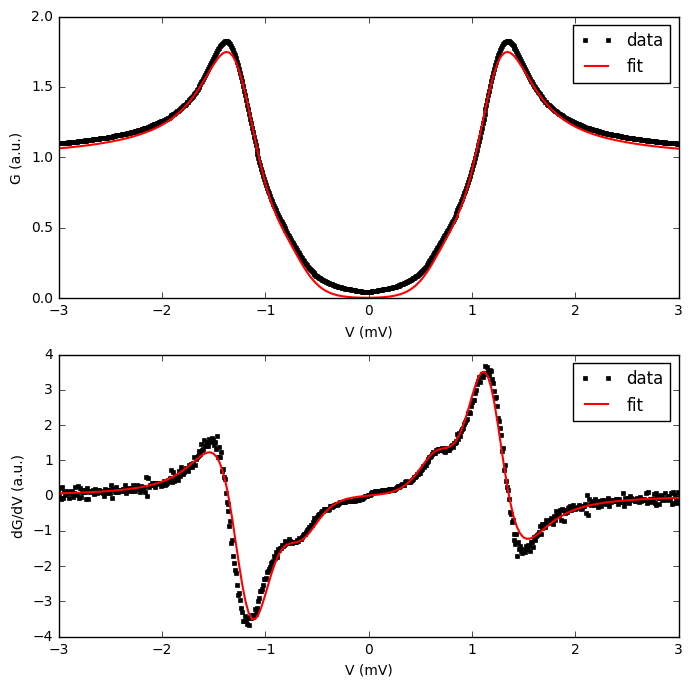

B =  45.3333333333


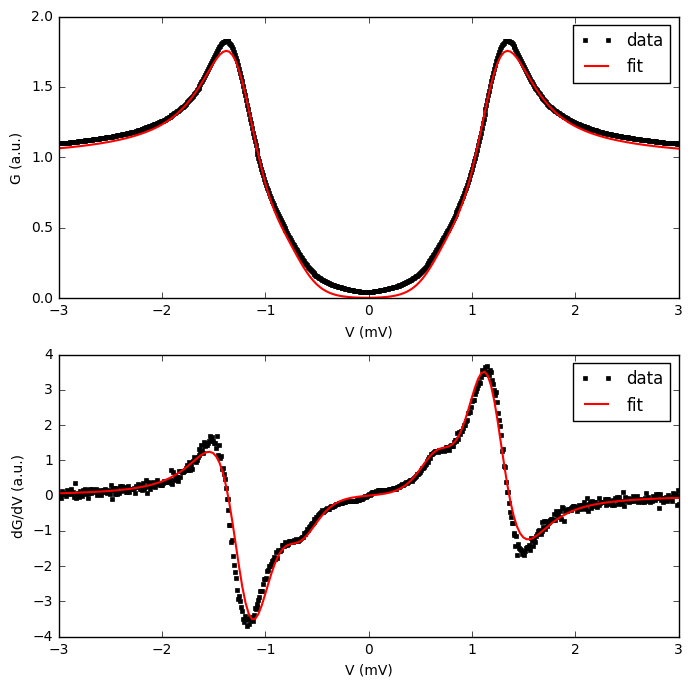

B =  46.6666666667


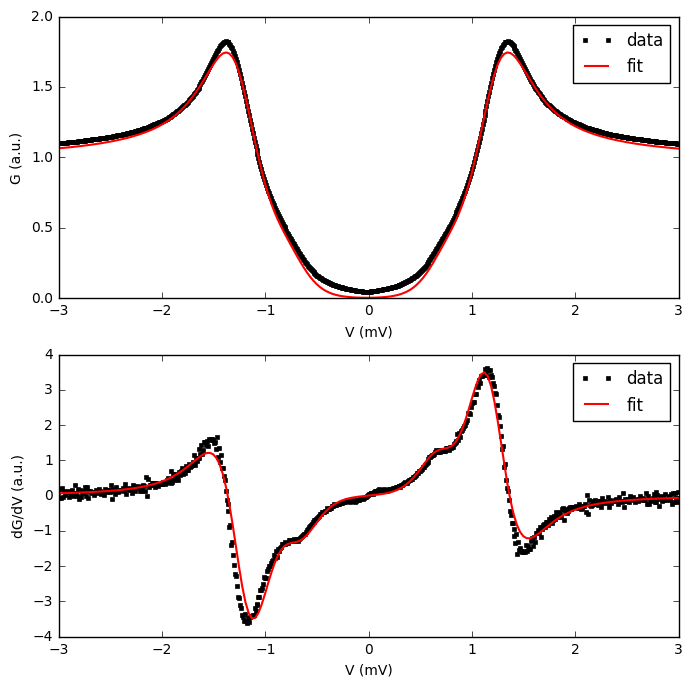

B =  48.0


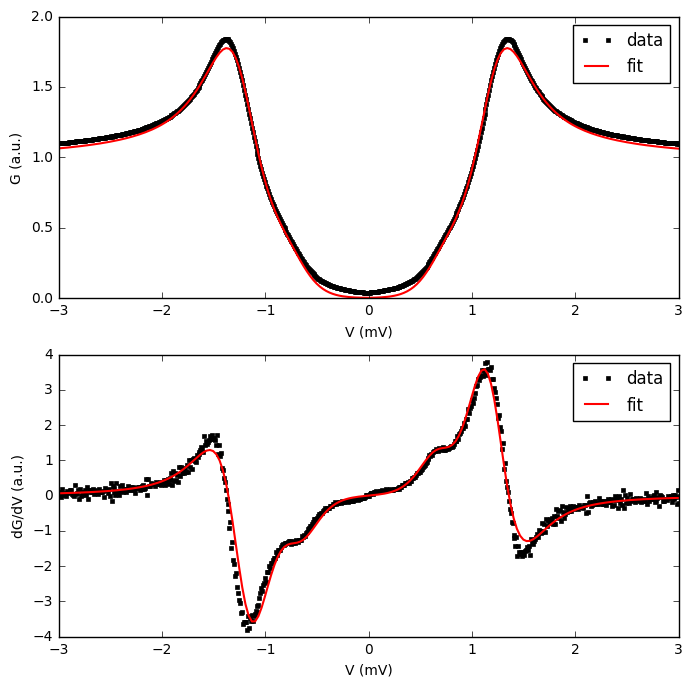

B =  49.3333333333


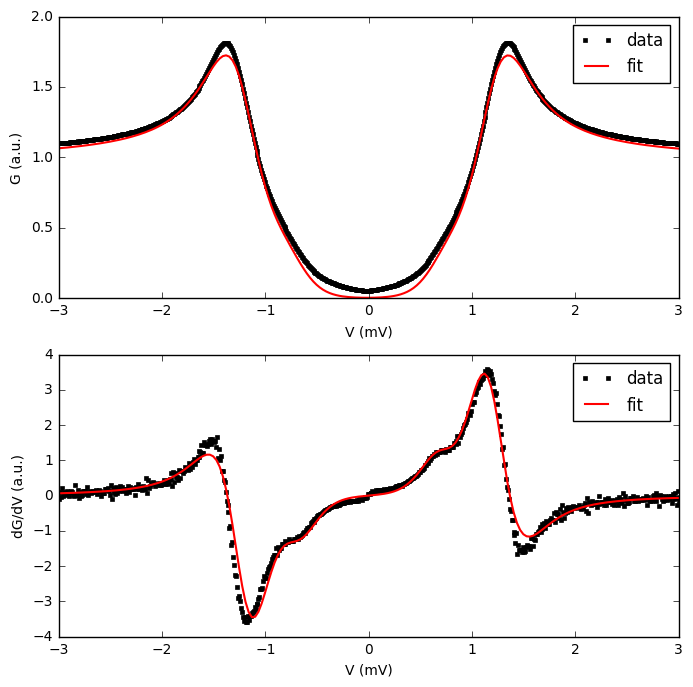

B =  50.6666666667


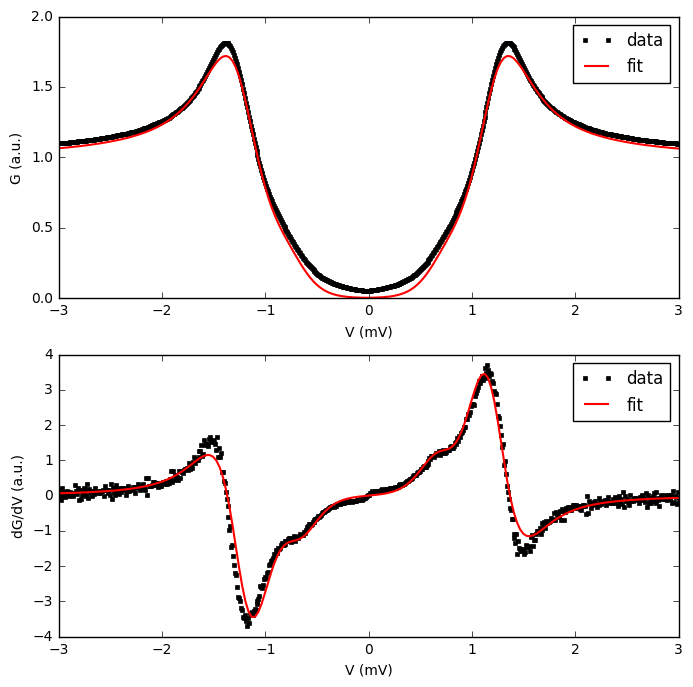

B =  52.0


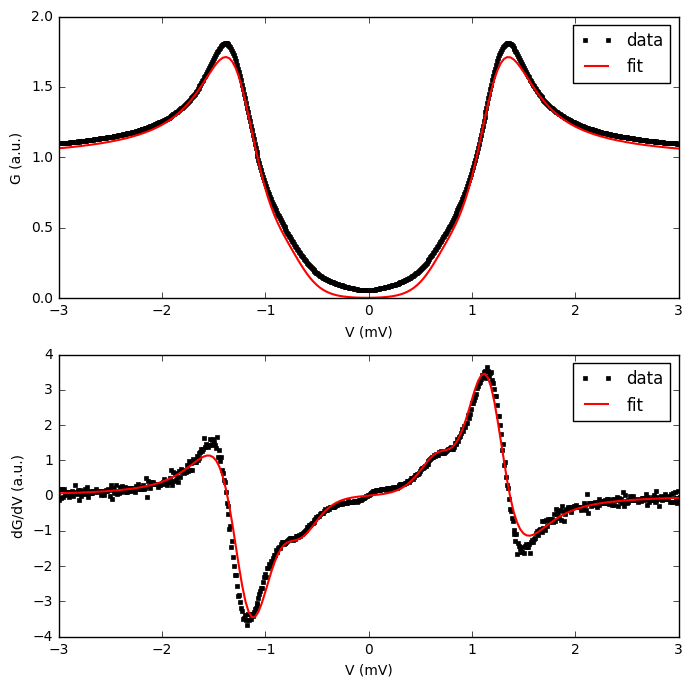

B =  53.3333333333


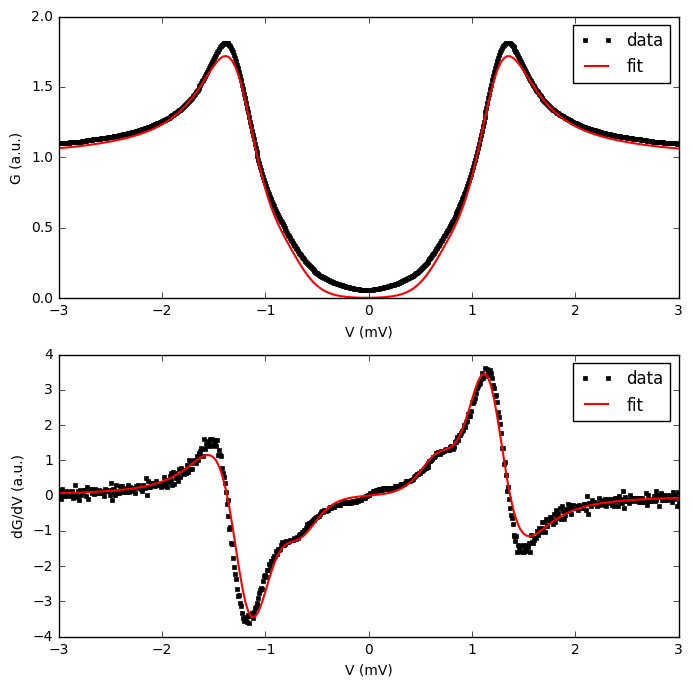

B =  54.6666666667


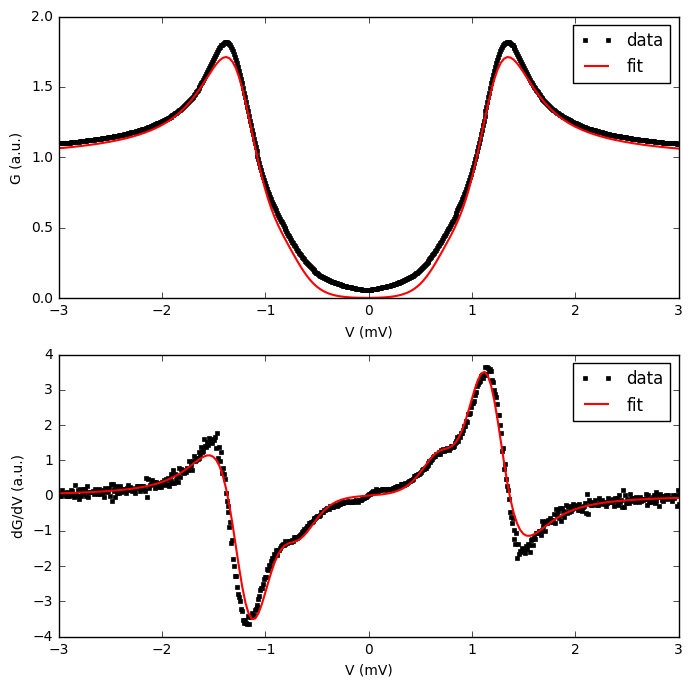

B =  56.0


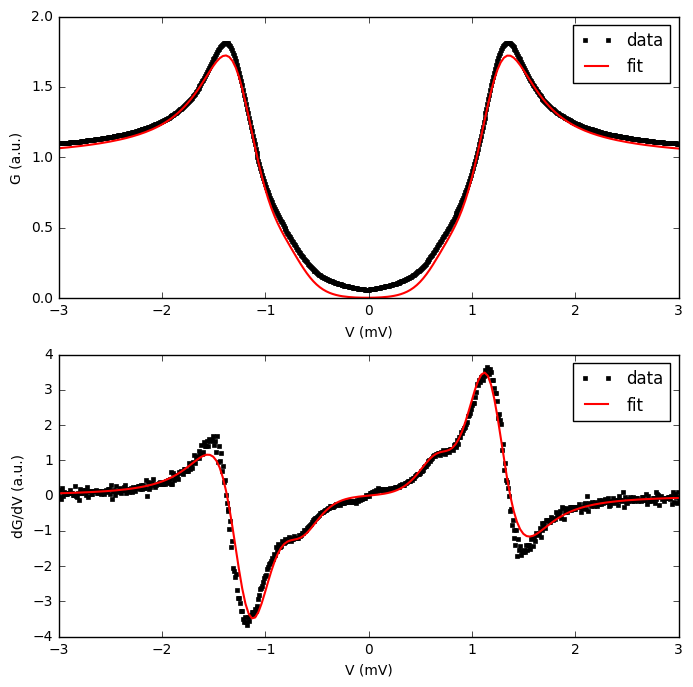

B =  57.3333333333


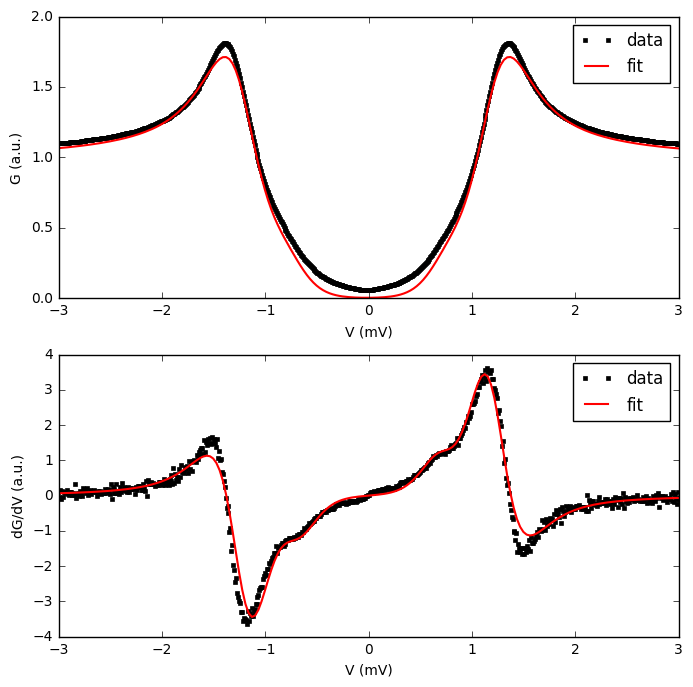

B =  58.6666666667


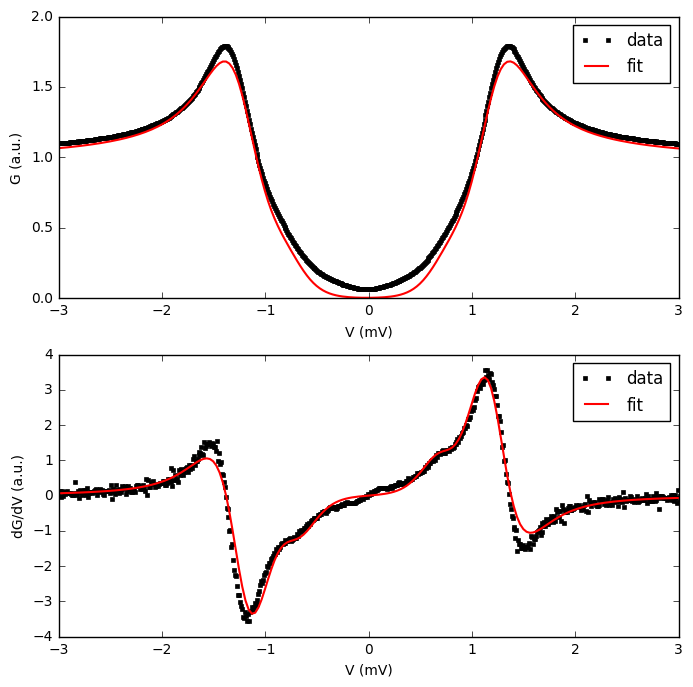

B =  60.0


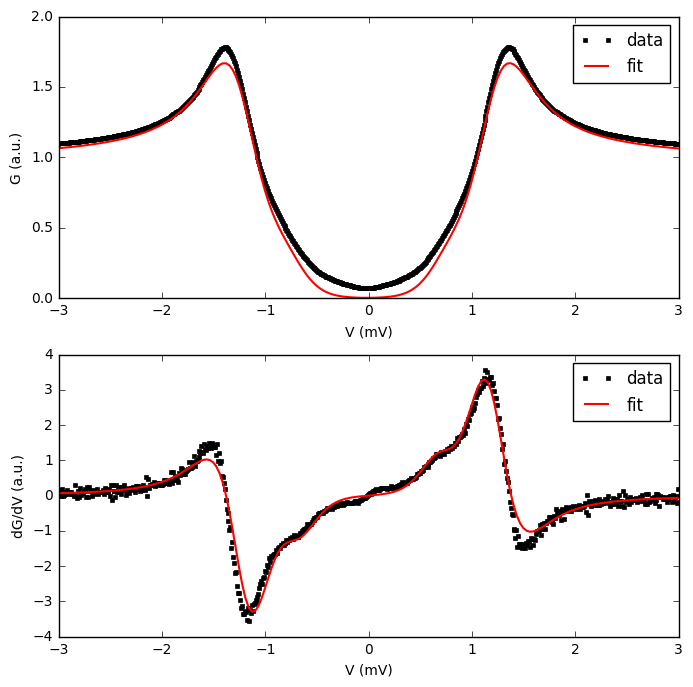

In [10]:
for k in range(46,0,-1):
    print('B = ',PerB[k-1])
    temp = numpy.flipud(PerFieldDataFreeDeltas)
    V, G, Gasym = LoadandSymmetrizePerField(k,-0.035)
    fig = LoadFitPlot(V,G,makeParamaters(temp[k-1]),[-3,3])
